In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import Tide_API as tide

__Methods in tide:__ <br>
- tide.get_tide(lat,lon,fn) <br>


In [3]:
#importing required packages
import h5py
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons
import numpy as np
from scipy.stats import gaussian_kde
import math
from sklearn.metrics import mean_absolute_error
import numpy as np

# Depth profile

In [35]:
#converts the hdf5 file to a pandas dataframe 

def get_photons(f):
    l1 = unpack_photons(f['heights'])
    return l1

#extracts the height, lat,lon and confidence of photons
def unpack_photons(f):
    height = f['h_ph'][...]
    print(height)
    lat = f['lat_ph'][...]
    lon = f['lon_ph'][...]
    print(lon)
    conf = f['signal_conf_ph'][...]
    print(conf)
    data = [height,lat,lon,conf]
    df = pd.DataFrame(data).T
    df.columns = ['Height', 'Latitude', 'Longitude','Confidence']
    return df

In [37]:
#splits the confidence array into individual columns
def individual_confidence(df):
    if df.shape[0] == 0:
        return df
    df['Conf_land'] = df.apply(lambda x: x.Confidence[0], axis = 1)
    df['Conf_ocean'] = df.apply(lambda x: x.Confidence[1], axis = 1)
    df['Conf_sea_ice'] = df.apply(lambda x: x.Confidence[2], axis = 1)
    df['Conf_land_ice'] = df.apply(lambda x: x.Confidence[3], axis = 1)
    df['Conf_inland_water'] = df.apply(lambda x: x.Confidence[4], axis = 1)
    return df

In [38]:
#calculates the mean confidence of the points
def mean_conf(row):
    r = row.copy()
    r = r[~np.isin(r, -1)]
    r = r[~np.isin(r, -2)]
    return np.round(np.mean(r))

In [39]:
def convert_h5_to_csv(fp,laser,coords,out_fp,fn):
    #reads in the hdf5 file
    f_df = h5py.File(fp,'r')
    #unpacks the hdf5 file to a pandas dataframe
    df_laser = get_photons(f_df[laser])
    #gets the coordinates that are within the coordinates passed into the function 
    df = df_laser.loc[(df_laser.Latitude > coords[0]) & (df_laser.Latitude < coords[1]) & (df_laser.Longitude > coords[2]) & (df_laser.Longitude < coords[3])]
    #unpacks the confidence array to individual columns
    df = individual_confidence(df)
    #gets the mean confidence 
    df['Conf_mean'] = df.Confidence.apply(mean_conf)
    #creates a file with the reef name if it does not exist 
    if not os.path.exists(out_fp):
        os.makedirs(out_fp)
    #writes a dataframe containing just the photon data that is required 
    df.to_csv(out_fp + '/'+ out_fp.split('/')[-1] + '_photons_' + fn.split('.')[0] + '_' + laser + '.csv')
    return

In [46]:
def plot(df,depth):
    f = water_level(df)
    m = df.loc[(df.Conf_ocean == 4) | (df.Conf_land == 4)]

    #readjusting depths to the sea level
    sea = f(m.Latitude)
    mean_sea = np.mean(sea)
    df.Height = df.Height - mean_sea
    m.Height = m.Height - mean_sea
    sea = sea - np.mean(sea)
    
    threshold = -0.3
    threshold_land = 2
    sea_level = m.loc[(m.Height > threshold) & (m.Height < threshold_land) ]
    reef = m.loc[m.Height <= threshold]
    land = m.loc[m.Height > threshold_land]
    fig,ax = plt.subplots()
    plt.scatter(sea_level.Latitude, sea_level.Height, s = 0.1)
    plt.scatter(reef.Latitude, reef.Height, s= 0.1, color = 'green')
    plt.scatter(land.Latitude, land.Height, s =0.1, color = 'brown')
    plt.xlabel('Latitude')
    plt.ylabel('Height (m)')

    #plotting depth predictions 
    plt.plot(m.Latitude, sea, linestyle='-', marker='o',color='blue', linewidth=2, markersize=2,alpha = 0.4)
    depth_prof = plt.plot(depth.Latitude, depth.Height, linestyle='-', marker='o',color='orange', linewidth=2, markersize=2,alpha = 0.4)



In [47]:
def water_level(df):
    all_p = df.copy()
    
    start = df.Latitude.min()
    end = df.Latitude.max()
    dx = 0.002
    
    thresh = 1
    
    df = df.loc[df.Conf_ocean == 4]
    df = df.loc[(df.Height > df.Height.median() - 2) & (df.Height < df.Height.median() + 2)]
    water = []
    lat = []

    sea_level = (pd.DataFrame([df.Height,df.Latitude]).T.dropna())
    sea_level.columns = ['water','latitude']
    
 
    sea_level = sea_level.loc[(sea_level.water > sea_level.water.median() -1.25) & (sea_level.water < sea_level.water.median() +1.25)]
    sea_level = sea_level.dropna(how = 'any')
    
    z = np.polyfit(sea_level.latitude, sea_level.water,1)
    f = np.poly1d(z)
    
    sea_level['abs_diff'] = np.abs(sea_level.water - f(sea_level.latitude))
#     plt.plot(lat, f(lat), color = 'orange')
    sea_level = sea_level.loc[sea_level.abs_diff < 2]
    
    z2 = np.polyfit(sea_level.latitude, sea_level.water,2)
    f2 = np.poly1d(z2)
    return f2

In [85]:
def depth_profile_adaptive(df, out_path,tide_level):
    #generating function to get the water level
    f = water_level(df)
    
    #creating copies of the dataset
    df = df.copy()
    m = df.copy()
    

    #subsetting the dataset by ICESAT confidence scores
    m = m.loc[(m.Conf_ocean == 4) | (m.Conf_land == 4)]
    
    #readjusting depths to the sea level
    sea = f(m.Latitude)
    mean_sea = np.mean(sea)
    df.Height = df.Height - mean_sea
    m.Height = m.Height - mean_sea
    sea = sea - np.mean(sea)
    
    #threshold below sea level for which we consider reefs 
    thresh = 1
    
    #generating arrays for the height, latitude 
    h = []
    l = []

    #getting the latitudes we will iterate through and the step
    start = df.Latitude.min()
    end = df.Latitude.max()
    dx = 0.0005
    
    #getting just high confidence land photons 
    df = df.loc[(df.Conf_land == 4)]
    
    #sorting photons by latitude
    df = df.sort_values('Latitude')
    
    #getting line for longitudes
    lon_samples = df.sample(1000)
    z1 = np.polyfit(lon_samples.Latitude, lon_samples.Longitude,1)
    lon_func = np.poly1d(z1)
    
    while start <= end:
        #subsetting photons that fall within window of size dx
#         temp = df.loc[(df.Latitude >= start-((dx/2))) & (df.Latitude <start+((dx/2)))]
        temp = df.loc[(df.Latitude >= start) & (df.Latitude <start+dx)]
        t = temp.copy()
        #getting the midpoint latitude of the window
        mean_lat = (temp.Latitude.max() + temp.Latitude.min()) / 2
        #subsetting photons 1m below sea level
        temp = temp.loc[(temp.Height < f(mean_lat) - mean_sea- thresh)]
        
        #getting the IQR of photons
        uq = temp["Height"].quantile(0.75)
        lq = temp["Height"].quantile(0.25)
        temp = temp.loc[(temp.Height >= lq) & (temp.Height < uq) ]        
        
        #if IQR contains more than 3 photons we proceed with the depth analysis
        if temp.shape[0] > 3:
            #getting depths that we will iterate throguh 
            min_depth = math.ceil(temp.Height.min()-1)
            max_depth = min(0,math.ceil(temp.Height.max()))
            median_depth = pd.DataFrame()
    
            #iterating through intervals of 0.5m at a time 
            for x in range(min_depth,max_depth):
                for y in range(2):
                    #subsetting photons within each 0.5m interval
                    depth_intervals = temp.loc[(temp.Height >= x + (y/2)) & (temp.Height < x+ ((y+1)/2))]
                    #if the interval contains one or more photons we will store the photon information for future calculations 
                    if depth_intervals.shape[0] >=1:
                        median_depth = pd.concat([depth_intervals,median_depth])
            
            #if more than 2 photons are saved from the previous step we set the median to be the predicted height
            if median_depth.shape[0] >= 2:
                h.append(median_depth.Height.median())
            else:
                #else nan
                h.append(np.nan)
            
            #append the mid point of the latitude to represent the latitude for the calculated height
            l.append((start + start+dx)/2)
#             print('first',l[-1],h[-1])
            #move to the next window
            start += dx
            
        #if the IQR does not contain more than 3 photons we use an adaptive window 
        else:
            #we have already completed the first iteration by checking if the window has more than 3 photons
            i = 2
            #boolean flag to check if we have met the requirements to make a prediction 
            bool_check = False
            #saving the starting latitude 
            ts = start
            #adaptive window check done at max 4 times 
            while i <= 4:
                #subset data in the window 
                temp = df.loc[(df.Latitude >= start-(i*(dx/2))) & (df.Latitude <start+(i*(dx/2)))]
                #get the midpoint of the latitudes in the window 
                mean_lat = (temp.Latitude.max() + temp.Latitude.min()) / 2
                #get photons more than 1m below sea level
                temp = temp.loc[(temp.Height < f(mean_lat) - mean_sea- thresh)]
                
                #setting counter to move to the next adaptive window
                i+=1
                #check if there are more than 30 photons in the window 
                if temp.shape[0] > 30:
                    
                    #find depths through which we will iterate
                    min_depth = math.ceil(temp.Height.min()-1)
                    max_depth = min(0,math.ceil(temp.Height.max()))
                    median_depth = pd.DataFrame()
                    #iterate through depths of 0.5m at a time 
                    for x in range(min_depth,max_depth):
                        for y in range(2):
                            depth_intervals = temp.loc[(temp.Height >= x + (y/2)) & (temp.Height < x+ ((y+1)/2))]
                            #if any depth interval has 2 or more photons, we will store that information for future use 
                            if depth_intervals.shape[0] >=1:
                                median_depth = pd.concat([depth_intervals,median_depth])
                    
                    #if we had more than photons saved from the previous step, we will preduct the median of those photons as the height
                    if median_depth.shape[0] >= 2:
                        #set the boolean flag to true 
                        bool_check = True
                        h.append(median_depth.Height.median())
                        #latitude for the given depth prediction is represented by the latitude midpoint 
                        l.append((start + start+dx)/2)
#                         print('l',l[-1],h[-1])
                        i = 5

            #if we did not meet any of the criteria we will predict nan for the height and the midpoint of the latitude for lat
            if bool_check == False:
                h.append(np.nan)
                l.append((start + start+dx)/2)
#                 print('e',l[-1],h[-1])
            #move to the next window
            start = ts + dx
        
    #remove noise
    for i,x in enumerate(h):
        if i == 0 or i == len(h) - 1 :
            continue
        else:

            if np.isnan(h[i-1]) and np.isnan(h[i+1]):
                if not np.isnan(x):
                    h[i] = np.nan
                
    #creating dataframe with the depth and latitudes
    depth = pd.DataFrame([h,l]).T
    depth.columns = ['Height','Latitude']
    depth['Longitude'] = (lon_func(depth.Latitude))


    d = depth.copy()
    d['Height'] = d['Height'] - tide_level
    d.to_csv(out_path)
    
    return depth

In [75]:
def get_depths(reef_name, fn, laser,coords):
    fp = os.path.join('data',reef_name, fn)
    out = os.path.join('data', reef_name)
    depths_fn = reef_name + '_' + fn.split('.')[0] + '_' + laser + '.csv'
    out_depths = os.path.join('data', reef_name, depths_fn)
    existing_file = os.path.join(out, str(reef_name) +'_photons_' + fn.split('.')[0] +'_' +laser + '.csv')
    if not os.path.exists(existing_file):
        convert_h5_to_csv(fp,laser,coords,out,fn)
    
    reef = pd.read_csv(existing_file)
    tide_level = tide.get_tide((coords[0]+coords[1])/2, (coords[2]+coords[3])/2,fn)
    print(tide_level)
    depth = depth_profile_adaptive(reef,out_depths,tide_level)
    return depth , reef

## DHIFFUSHI (MALDIVES)

-0.003


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


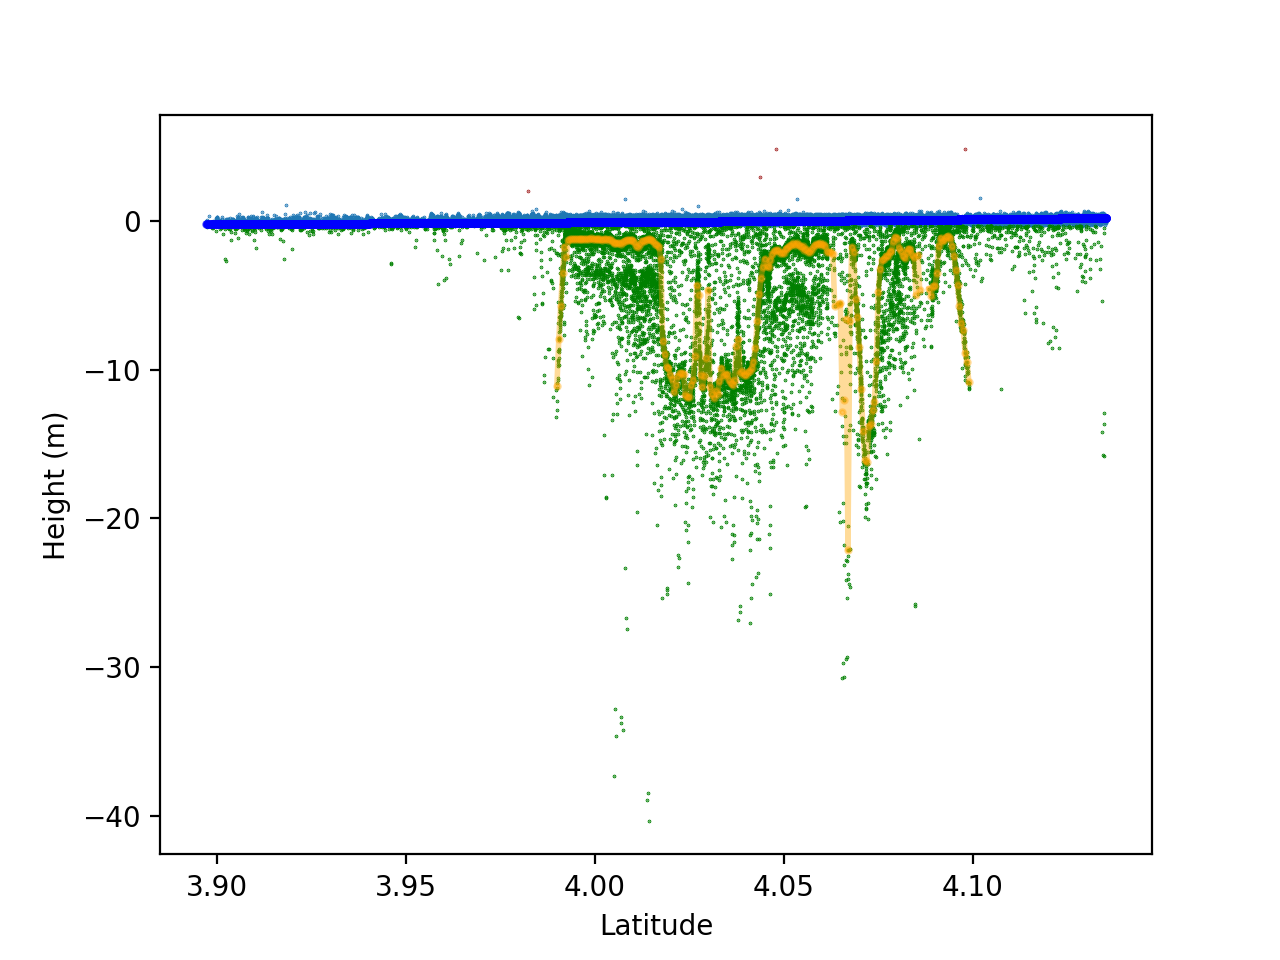

In [76]:
dhiffushi_coords = [3.803554,4.135101,73.340536,73.548742] 
dhiffushi_depth,dhiffushi = get_depths('Dhiffushi', 'ATL03_20181031214459_05080107_001_01.h5', 'gt1r',dhiffushi_coords )
plot(dhiffushi,dhiffushi_depth)

-0.003


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


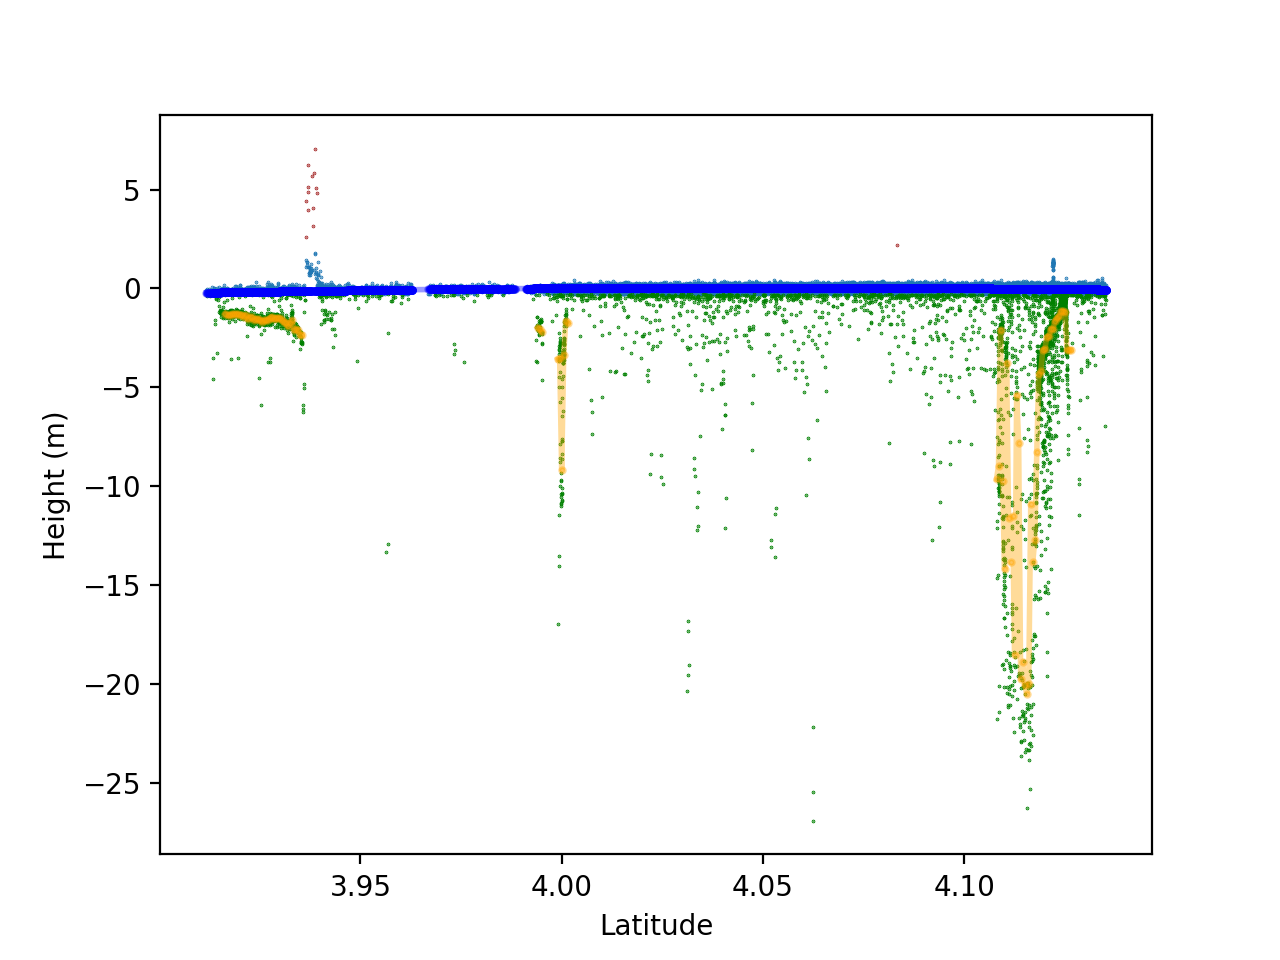

In [77]:
dhiffushi_depth2,dhiffushi2 = get_depths('Dhiffushi', 'ATL03_20181031214459_05080107_001_01.h5', 'gt2r',dhiffushi_coords )
plot(dhiffushi2,dhiffushi_depth2)

-0.003


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


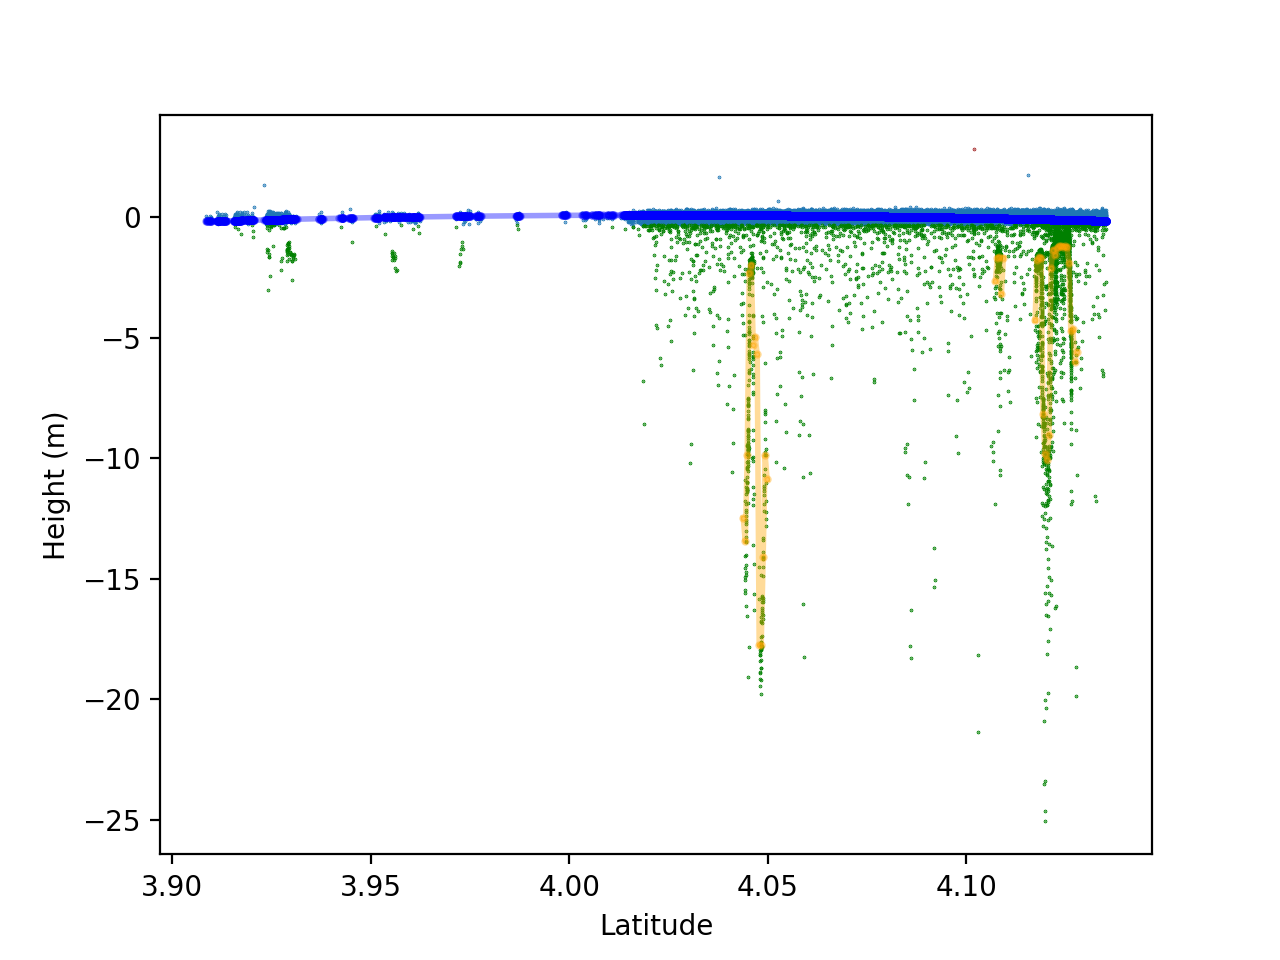

In [78]:
dhiffushi_depth3,dhiffushi3 = get_depths('Dhiffushi', 'ATL03_20181031214459_05080107_001_01.h5', 'gt3r',dhiffushi_coords )
plot(dhiffushi3,dhiffushi_depth3)

0.19


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


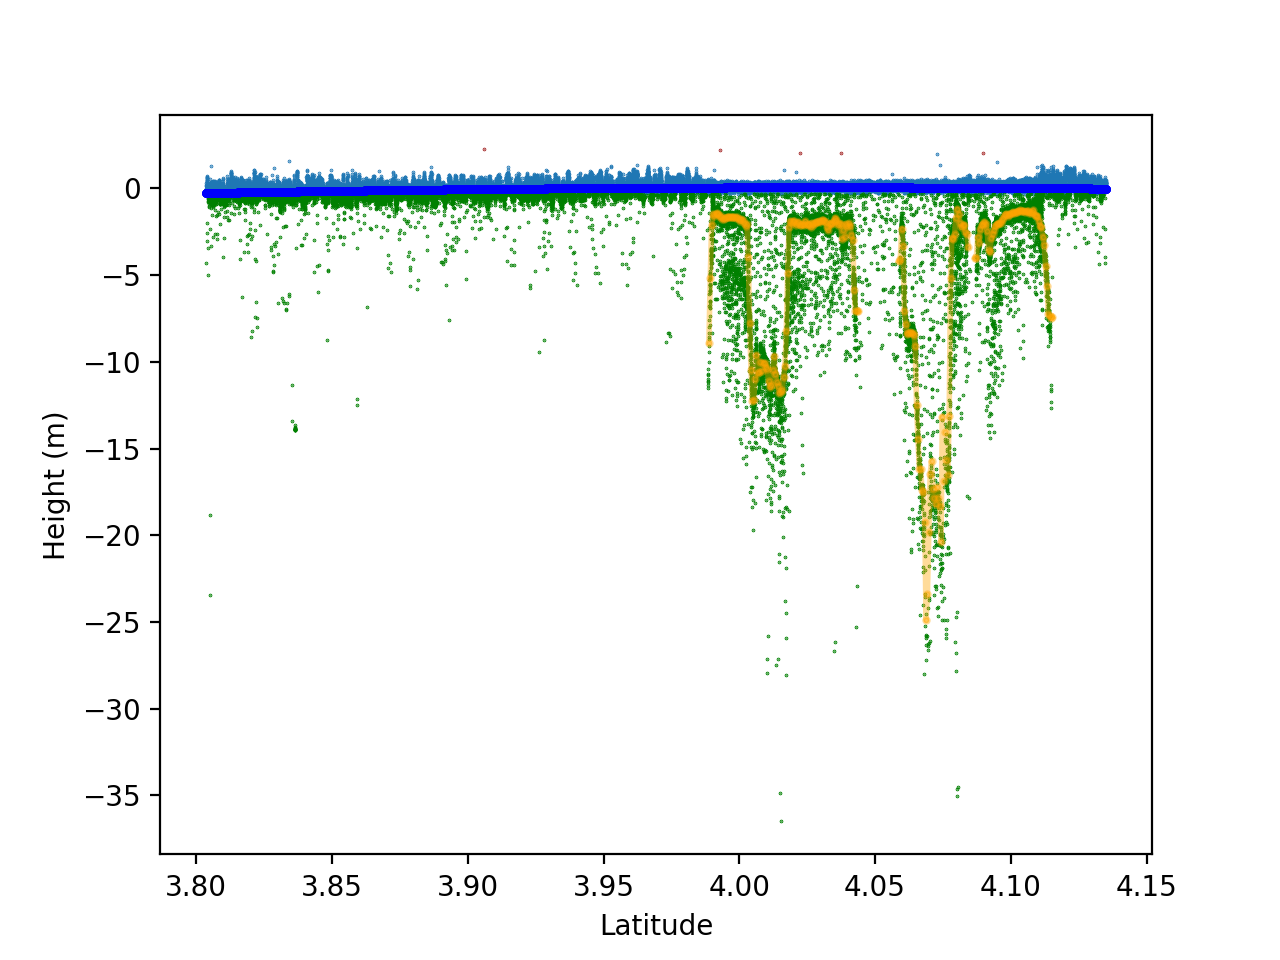

In [79]:
dhiffushi_depth4, dhiffushi4 = get_depths('Dhiffushi', 'ATL03_20190130172455_05080207_001_01.h5', 'gt2l', dhiffushi_coords)
plot(dhiffushi4,dhiffushi_depth4)

0.19


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


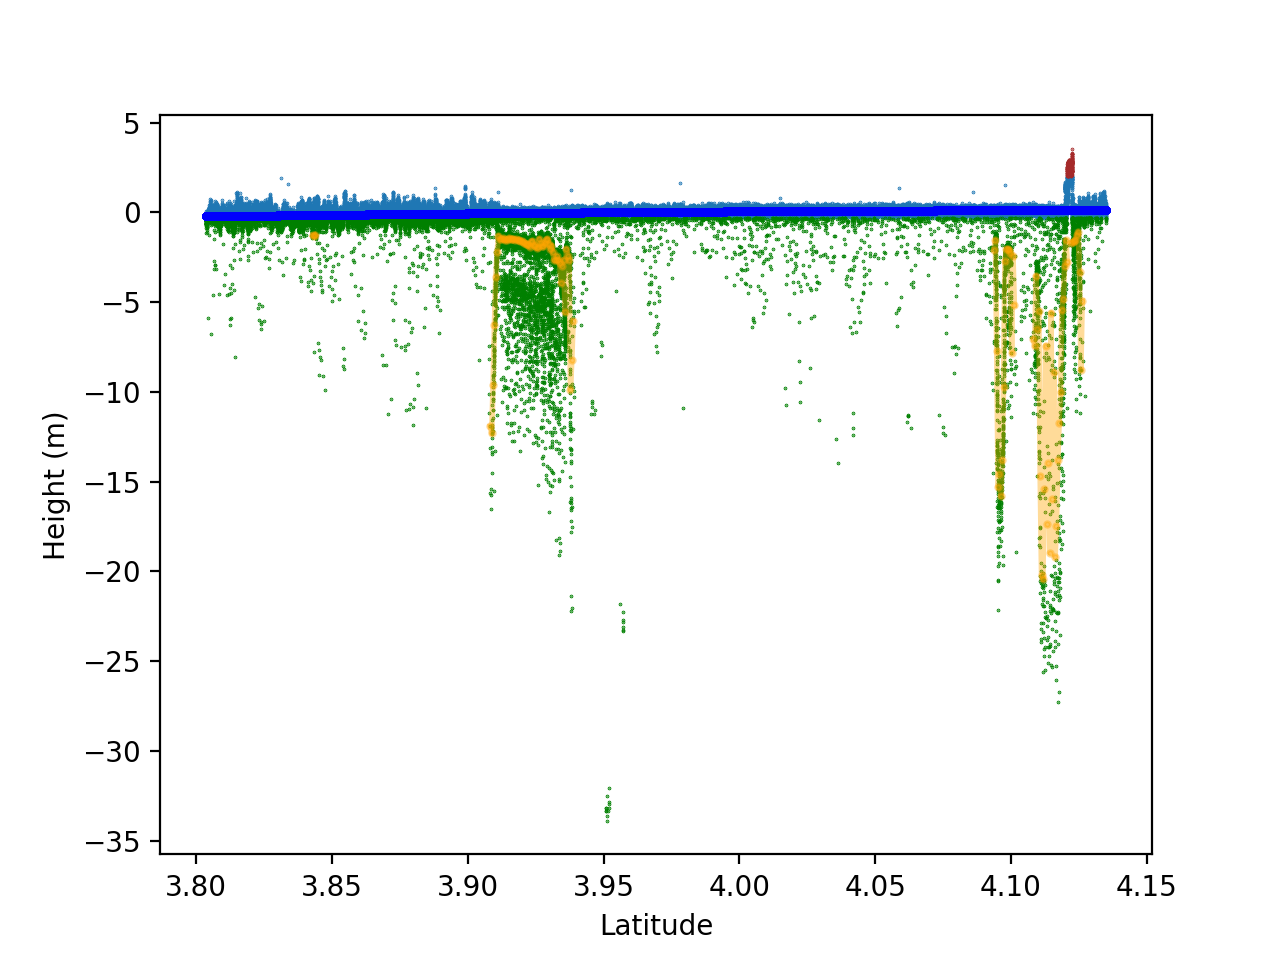

In [80]:
dhiffushi_depth5, dhiffushi5 = get_depths('Dhiffushi', 'ATL03_20190130172455_05080207_001_01.h5', 'gt3l', dhiffushi_coords)
plot(dhiffushi5,dhiffushi_depth5)

## RASDHOO (MALDIVES)

0.146


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


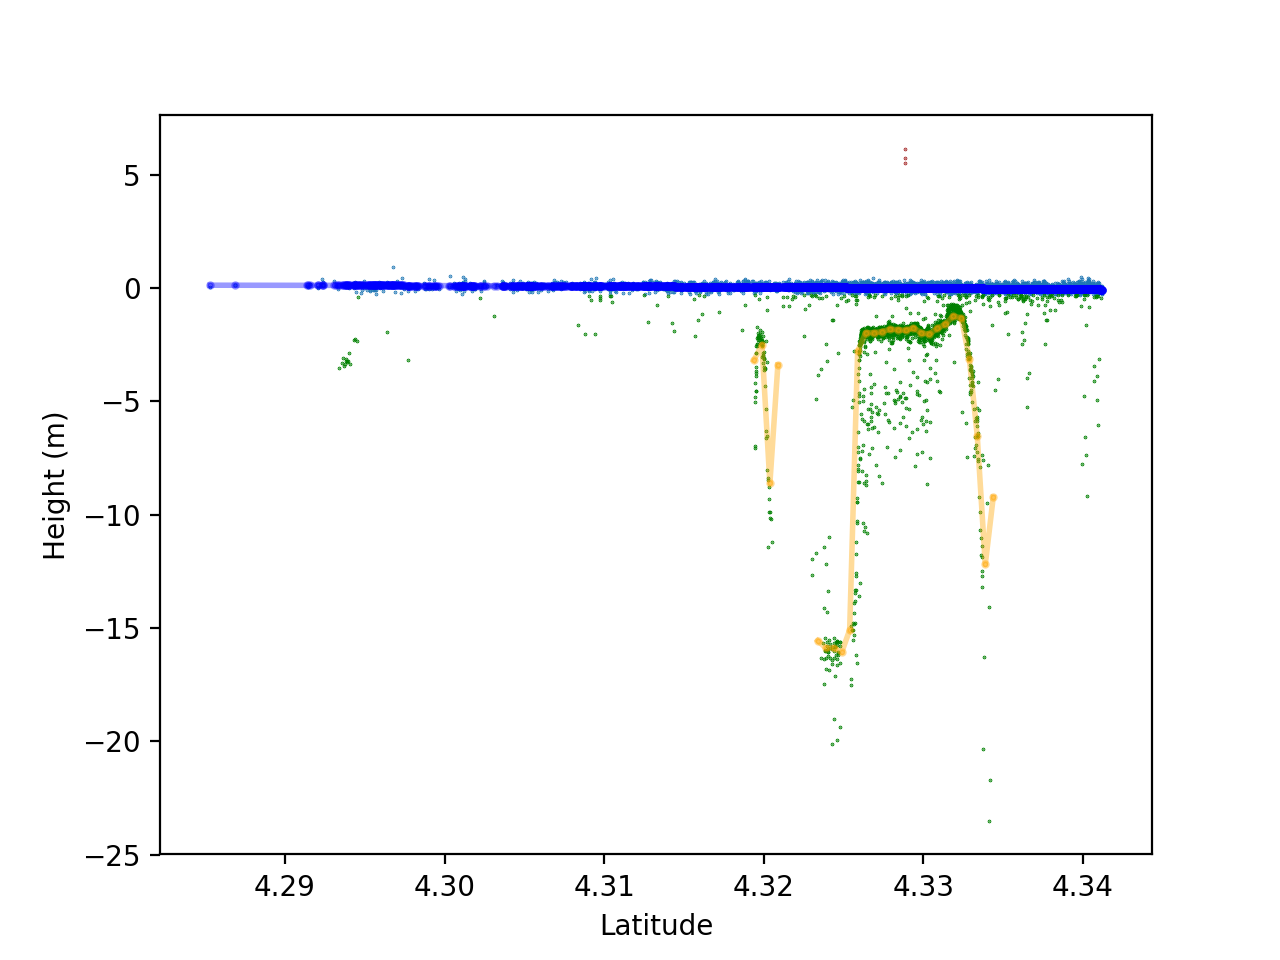

In [81]:
rasdhoo_coords = [4.2459,4.3412,72.9227,73.269]
rasdhoo_depth, rasdhoo = get_depths('Rasdhoo', 'ATL03_20181203201237_10110107_001_01.h5', 'gt3r',rasdhoo_coords )
plot(rasdhoo,rasdhoo_depth)

## Yoron

0.387


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


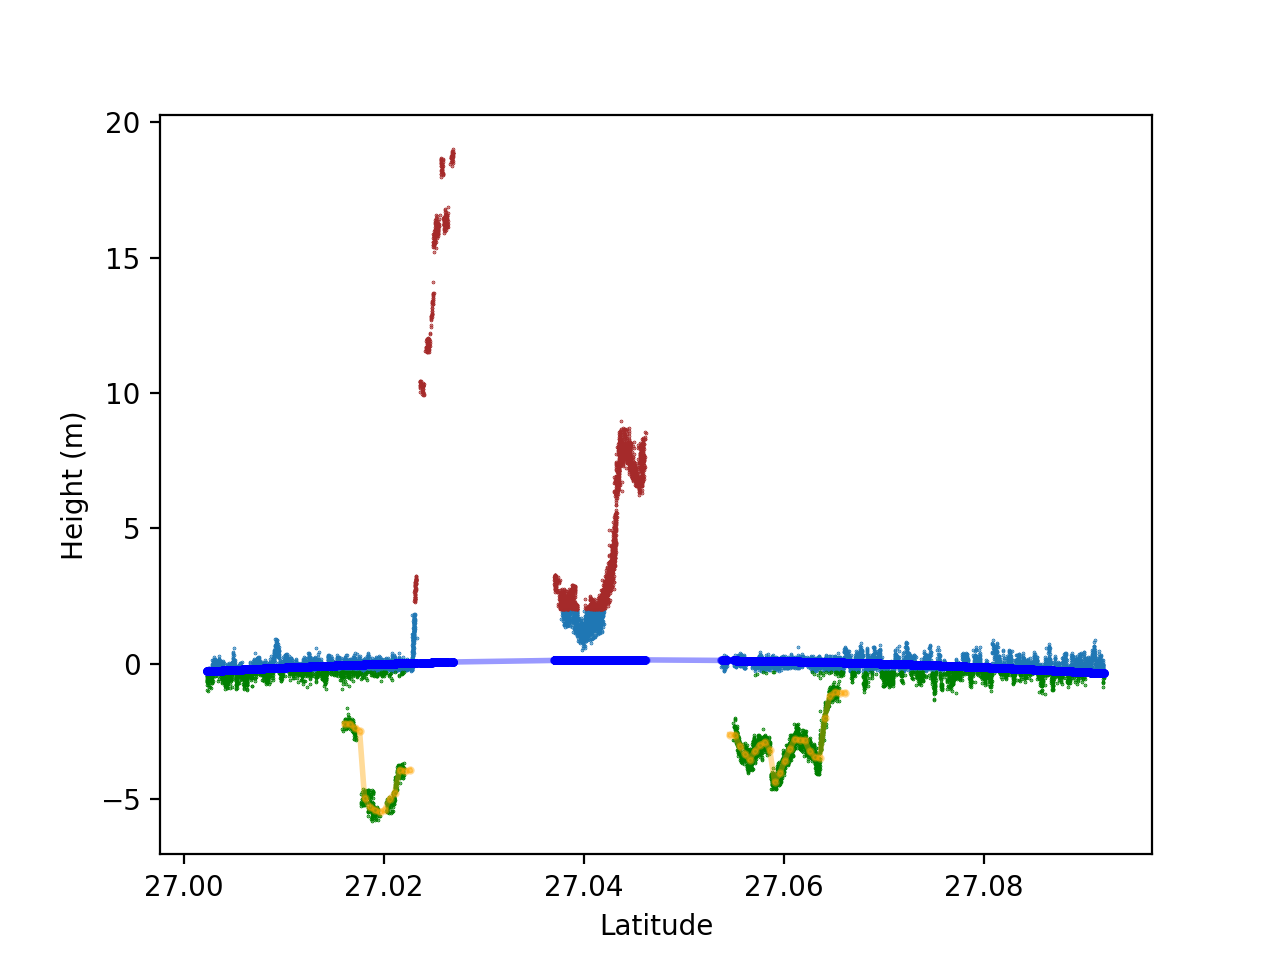

In [82]:
yoron_coords = [27, 27.0920,128.3737,128.4848]
yoron_depths, yoron = get_depths('Yoron', 'ATL03_20181021063658_03460102_001_01.h5', 'gt2r',yoron_coords )
plot(yoron,yoron_depths)

## Miyako

0.299


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


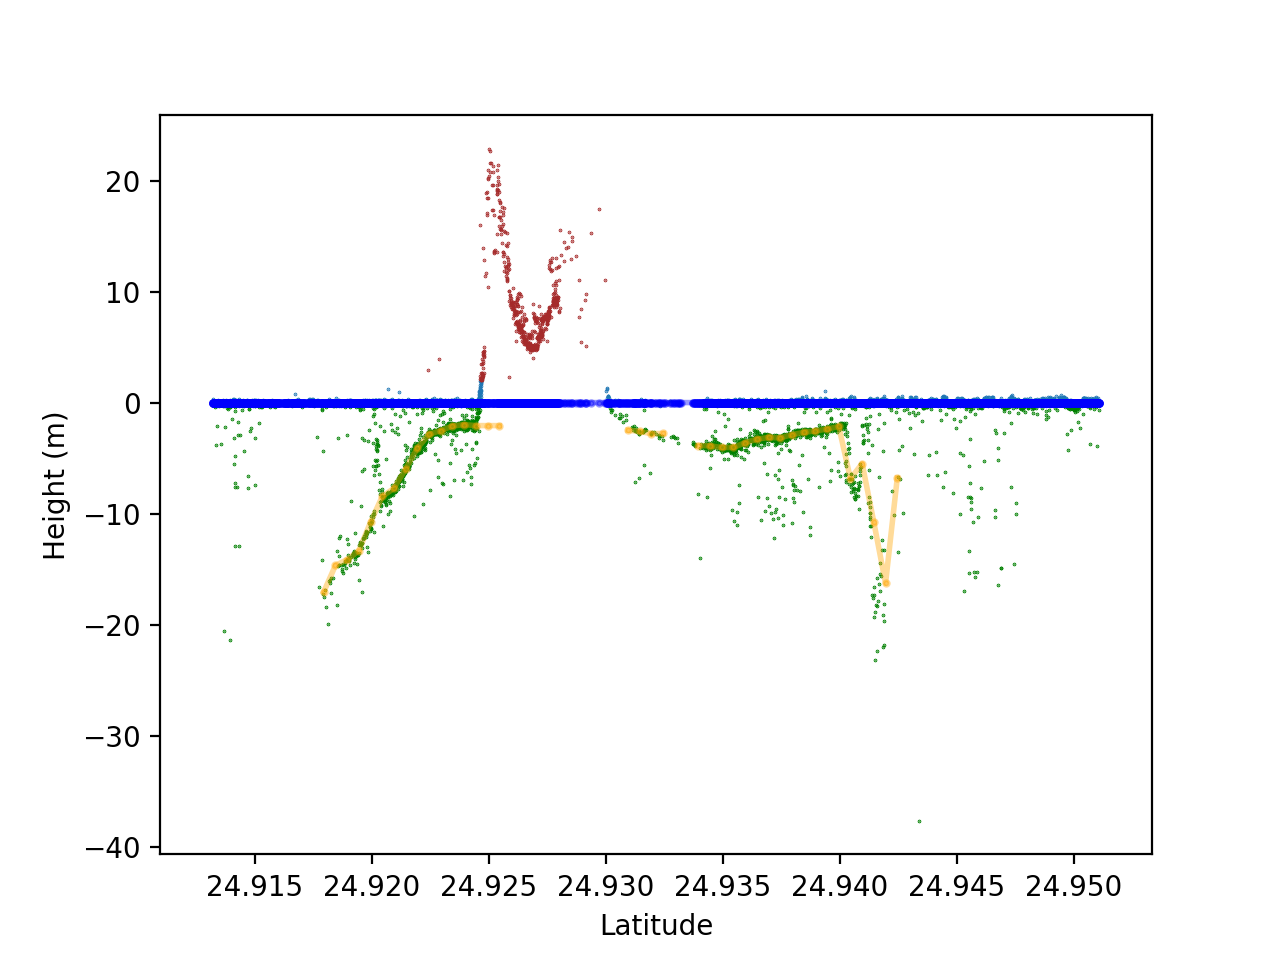

In [86]:
miyako_coords = [24.9132, 24.9511,125.2191,125.2619]
miyako_depths, miyako = get_depths('Miyako', 'ATL03_20181019190118_03230107_001_01.h5', 'gt1r',miyako_coords )
plot(miyako,miyako_depths)

## The Great Blue Hole (Belize)

[-267.04724 -258.90042 -258.5473  ...  122.22976  124.04293  118.23406]
[-85.77794135 -85.77794123 -85.77794123 ... -88.55573009 -88.55573005
 -88.55573019]
[[-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 ...
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


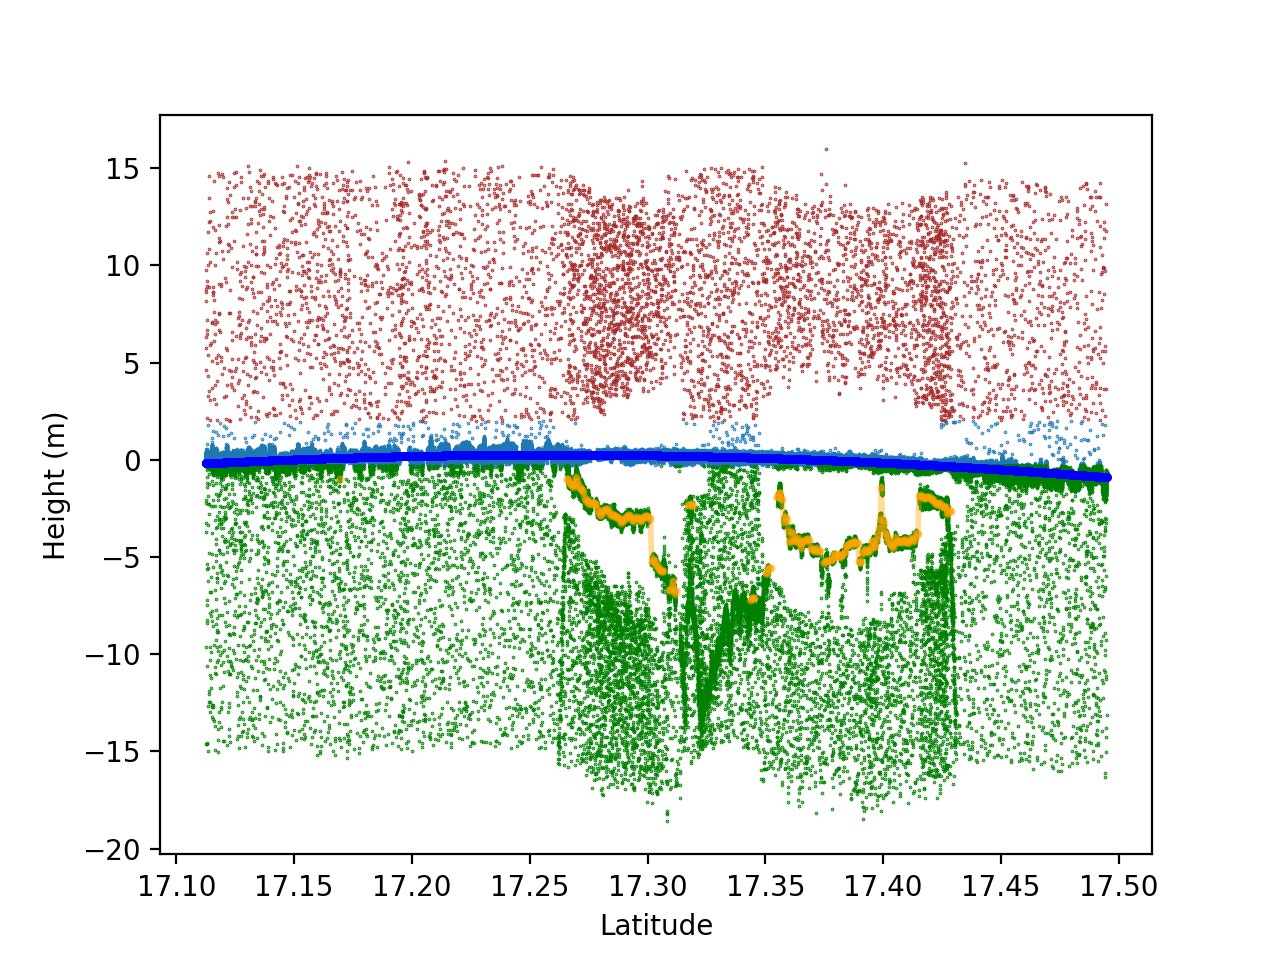

In [32]:
gbh_coords = [17.1125,17.4949,-87.6249,-87.4368]
gbh_depths, gbh = get_depths('Great_Blue_Hole', 'ATL03_20181213182436_11630101_001_01.h5', 'gt1r',gbh_coords )

[101.87519   76.011215  97.58574  ...  75.68786   83.33647   76.56648 ]
[-85.75024548 -85.75024421 -85.75024591 ... -88.52618063 -88.52618236
 -88.52618205]
[[-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 ...
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


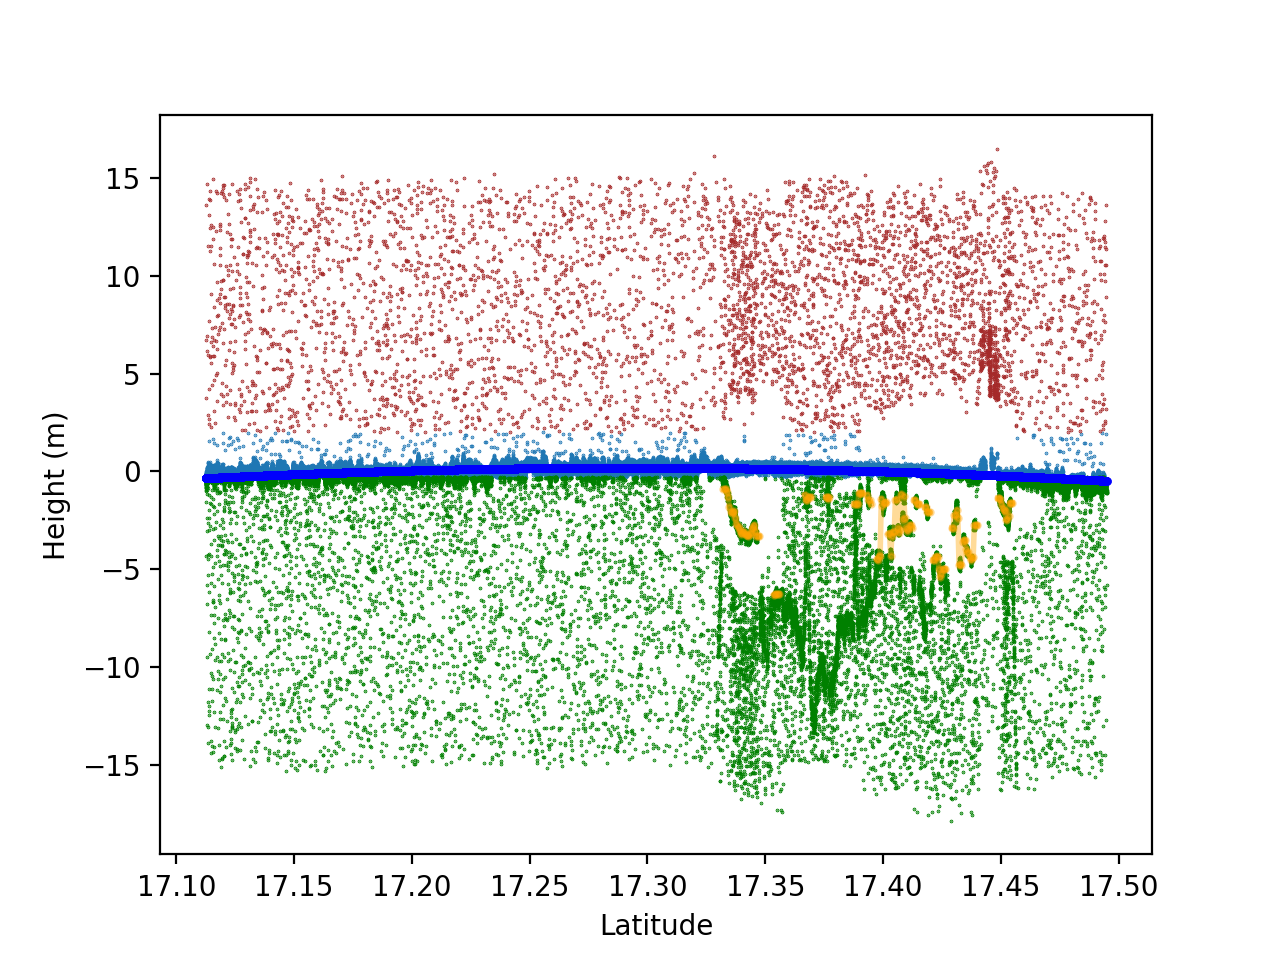

In [33]:
gbh_depths2, gbh2 = get_depths('Great_Blue_Hole', 'ATL03_20181213182436_11630101_001_01.h5', 'gt2r',gbh_coords )

[-119.39901 -147.29068 -139.67828 ... -151.26334 -164.57103 -155.11446]
[-85.72017233 -85.7201692  -85.72017006 ... -88.49156988 -88.49156832
 -88.49157015]
[[-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 ...
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


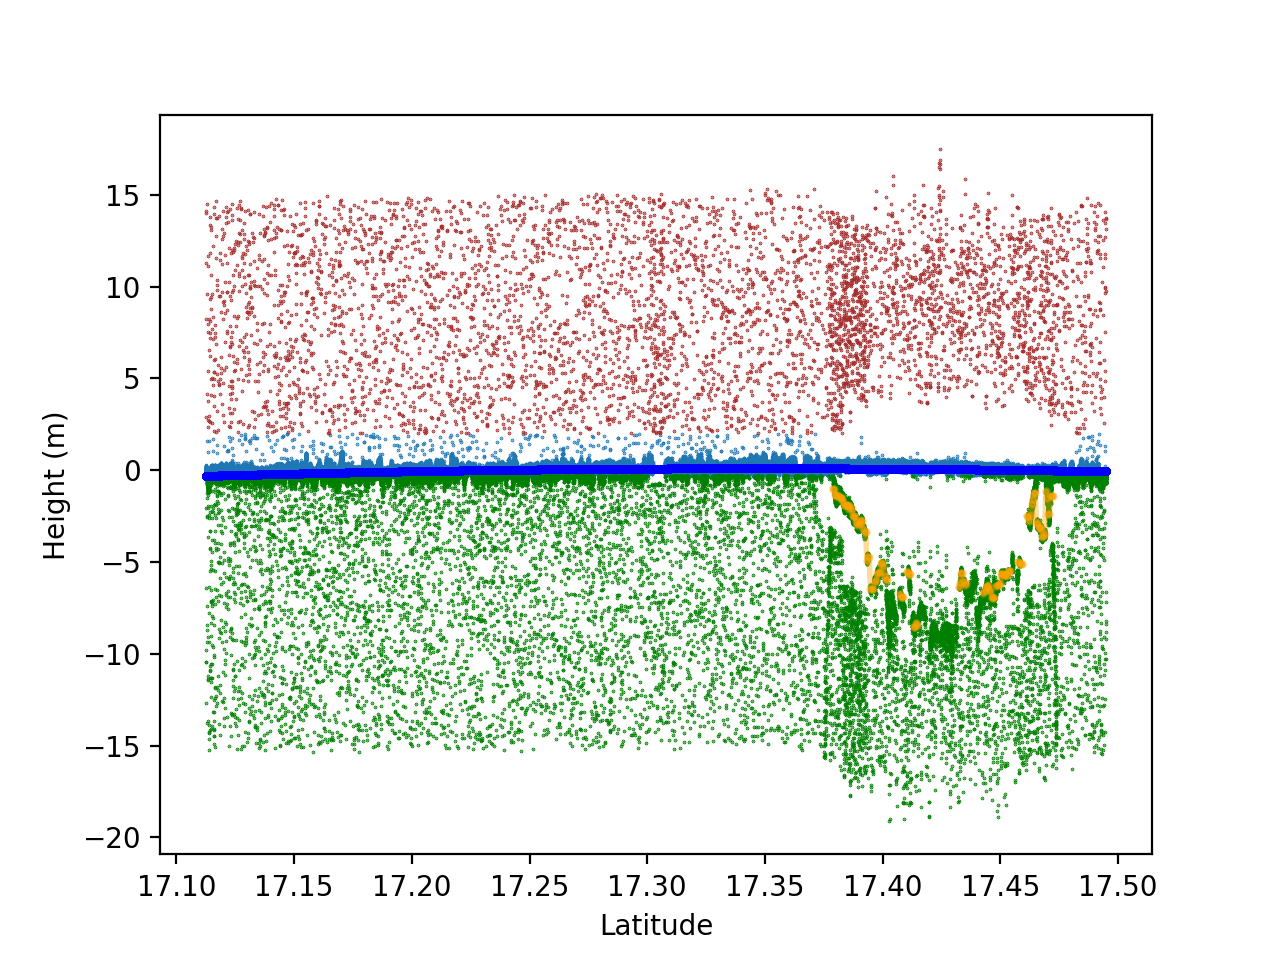

In [34]:
gbh_depths3, gbh3 = get_depths('Great_Blue_Hole', 'ATL03_20181213182436_11630101_001_01.h5', 'gt3r',gbh_coords )

## North Eleuthera (Bahamas)

[-15.779631 -32.943455 -67.02588  ... -37.13524  -37.2086   -67.96884 ]
[-76.64977422 -76.64978312 -76.64978308 ... -76.72834084 -76.72834156
 -76.72834154]
[[ 0  0 -1 -1 -1]
 [ 2  2 -1 -1 -1]
 [ 0  0 -1 -1 -1]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 0  0 -1 -1  0]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


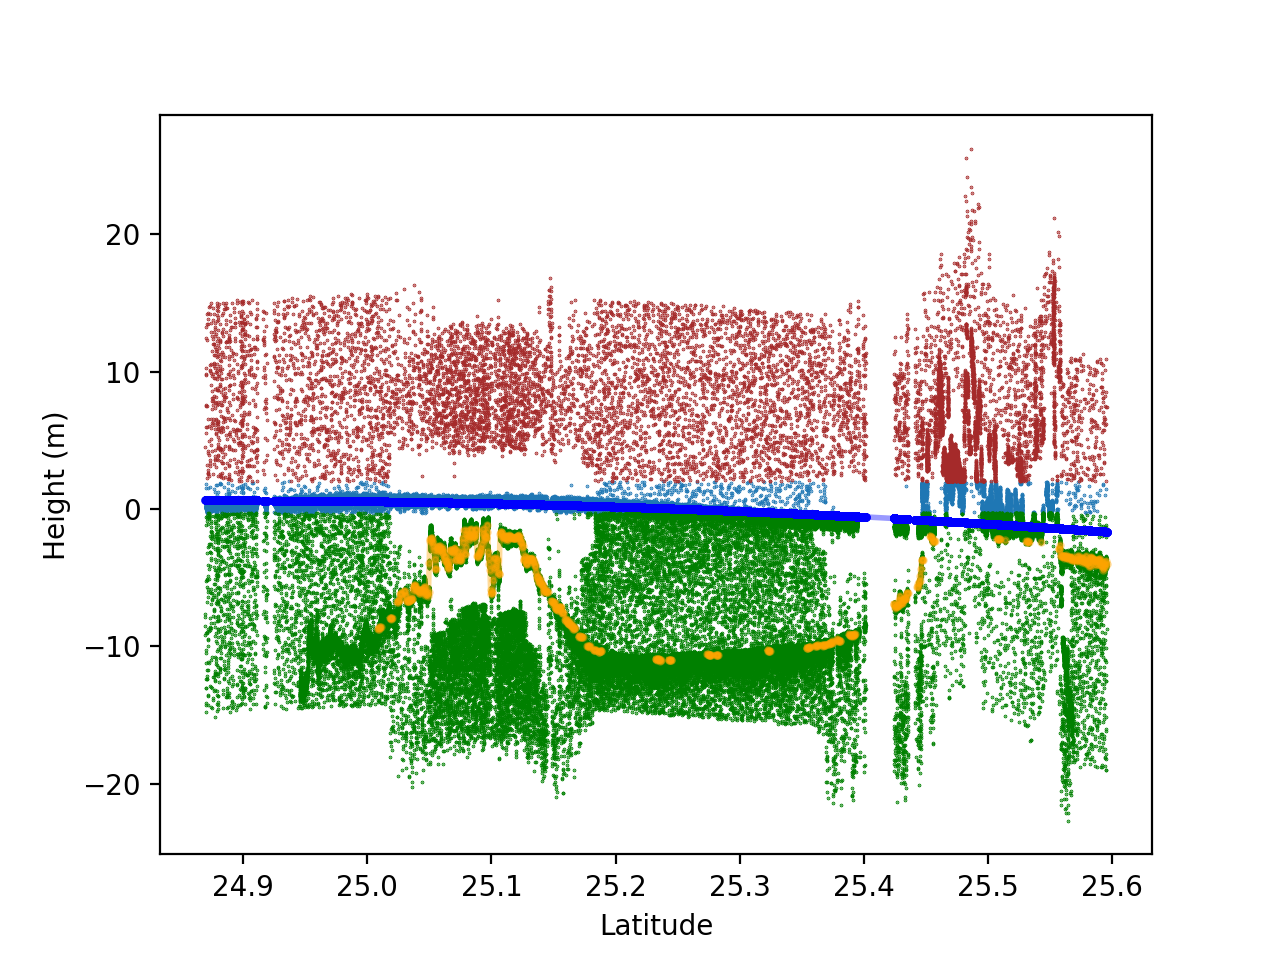

In [39]:
eleuthera_coords = [24.8695,25.5953,-76.8009,-76.5730]
eleuthera_depth, eleuthera = get_depths('North_Eleuthera', 'ATL03_20181014202933_02480101_001_01.h5', 'gt1r',eleuthera_coords )

[ -33.21217  -33.2636   -33.15762 ... -105.71874 -101.79776  -91.41282]
[-76.61799731 -76.61799731 -76.61799802 ... -76.69636868 -76.69636896
 -76.6963704 ]
[[ 4  4 -1 -1 -1]
 [ 4  4 -1 -1 -1]
 [ 4  4 -1 -1 -1]
 ...
 [ 0  0 -1 -1  0]
 [ 0  0 -1 -1  0]
 [ 0  0 -1 -1  0]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


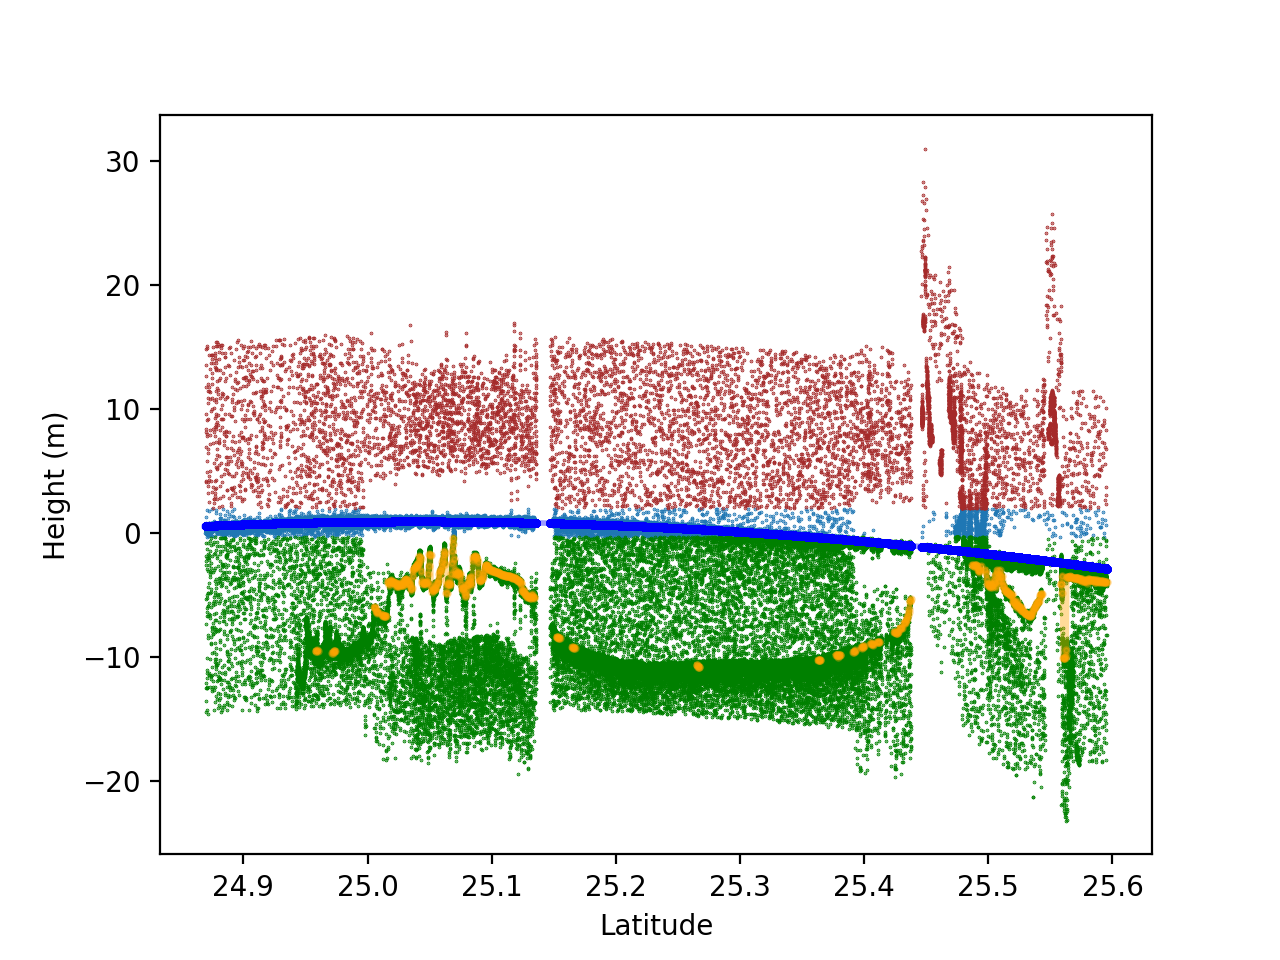

In [40]:
eleuthera_depth2, eleuthera2 = get_depths('North_Eleuthera', 'ATL03_20181014202933_02480101_001_01.h5', 'gt2r',eleuthera_coords )

[-33.6541   -33.968597 -33.426044 ... -36.95686  -37.061024 -59.75222 ]
[-76.58623922 -76.58623917 -76.58623925 ... -76.66443826 -76.66443825
 -76.66443504]
[[ 4  4 -1 -1 -1]
 [ 4  1 -1 -1 -1]
 [ 4  4 -1 -1 -1]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 0  0 -1 -1  0]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


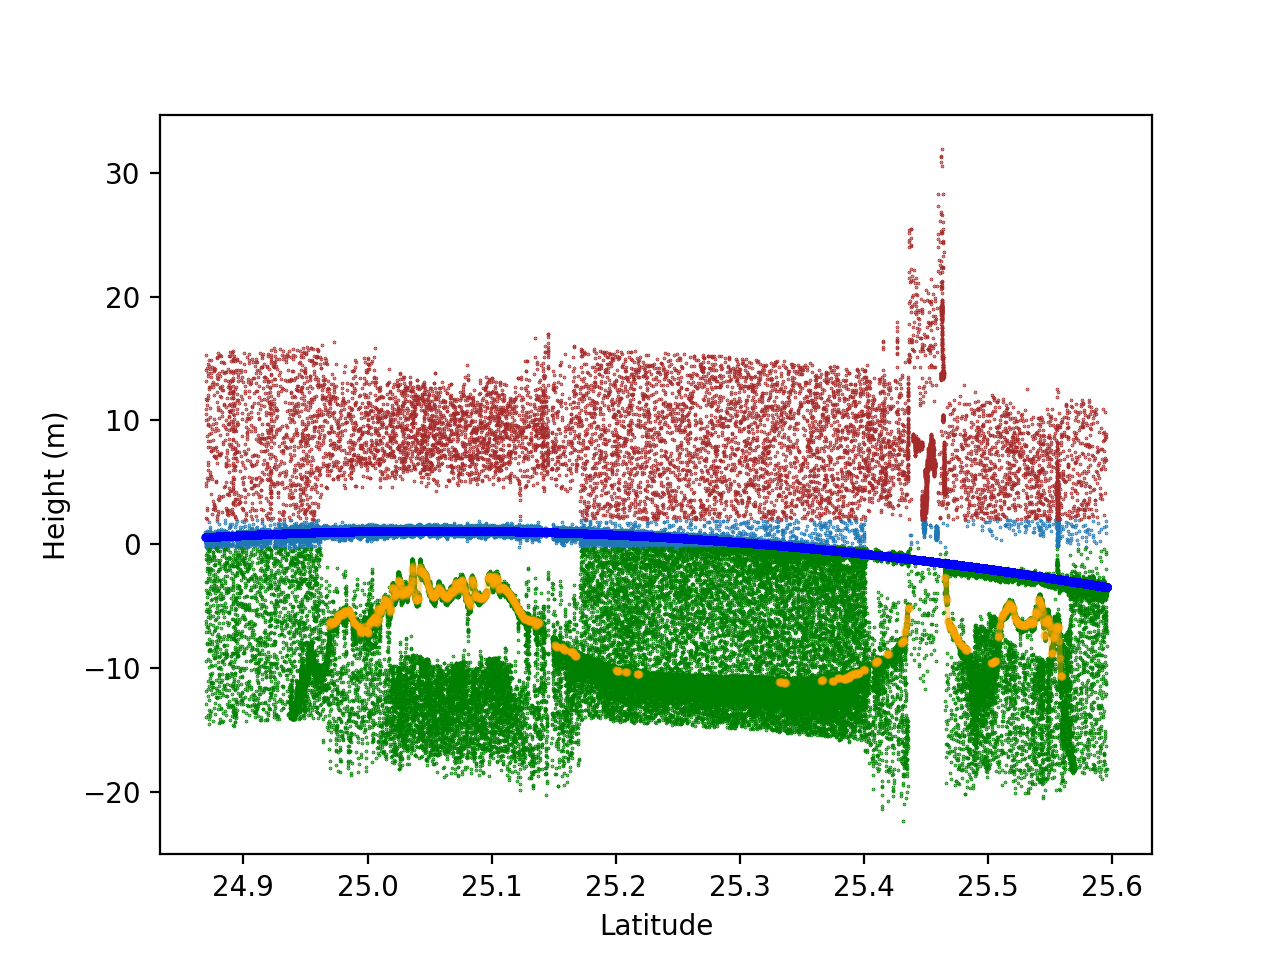

In [41]:
eleuthera_depth3, eleuthera3 = get_depths('North_Eleuthera', 'ATL03_20181014202933_02480101_001_01.h5', 'gt3r',eleuthera_coords )

In [ ]:
eleuthera_depth4, eleuthera4 = get_depths('North_Eleuthera', 'ATL03_20190113160921_02480201_001_01.h5', 'gt1l',eleuthera_coords )

[ 610.3951   557.62036  547.43164 ... -155.62971 -151.25687 -196.08978]
[-74.12369117 -74.1236971  -74.12369825 ... -76.90806667 -76.90806611
 -76.90807191]
[[ 0 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1]
 ...
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]
 [-1  0 -1 -1 -1]]


In [ ]:
eleuthera_depth5, eleuthera5 = get_depths('North_Eleuthera', 'ATL03_20190113160921_02480201_001_01.h5', 'gt2l',eleuthera_coords )

In [ ]:
eleuthera_depth6, eleuthera6 = get_depths('North_Eleuthera', 'ATL03_20190113160921_02480201_001_01.h5', 'gt3l',eleuthera_coords )

## Rodrigues (Mauritius)

<IPython.core.display.Javascript object>


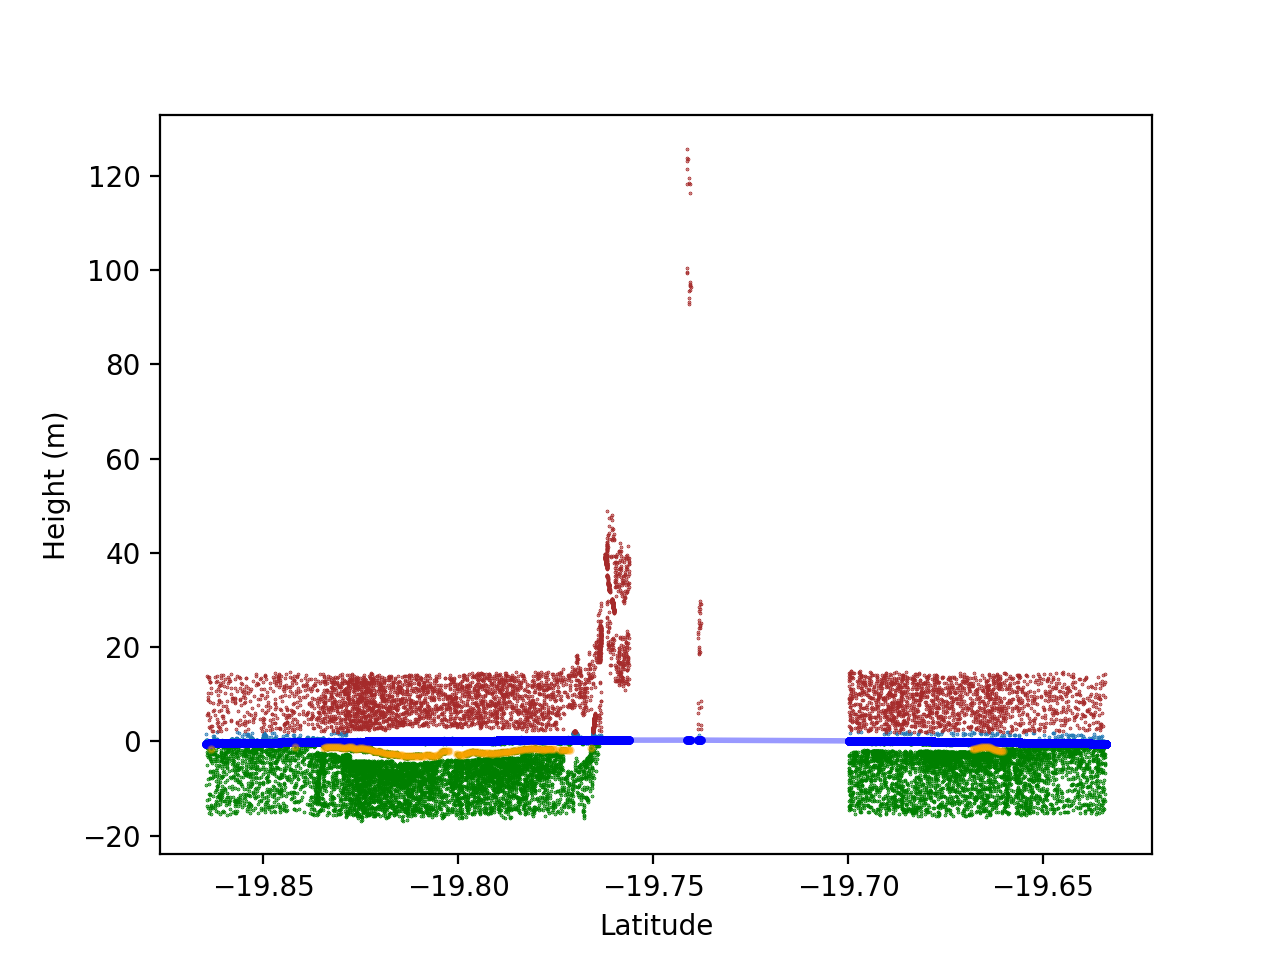

In [247]:
rodrigues_coords = [-19.8646,-19.6339,63.3358,63.4642]
rodrigues_depth, rodrigues = get_depths('Rodrigues', 'ATL03_20190214053007_07290214_001_01.h5', 'gt1l',rodrigues_coords )

## Toau

<IPython.core.display.Javascript object>


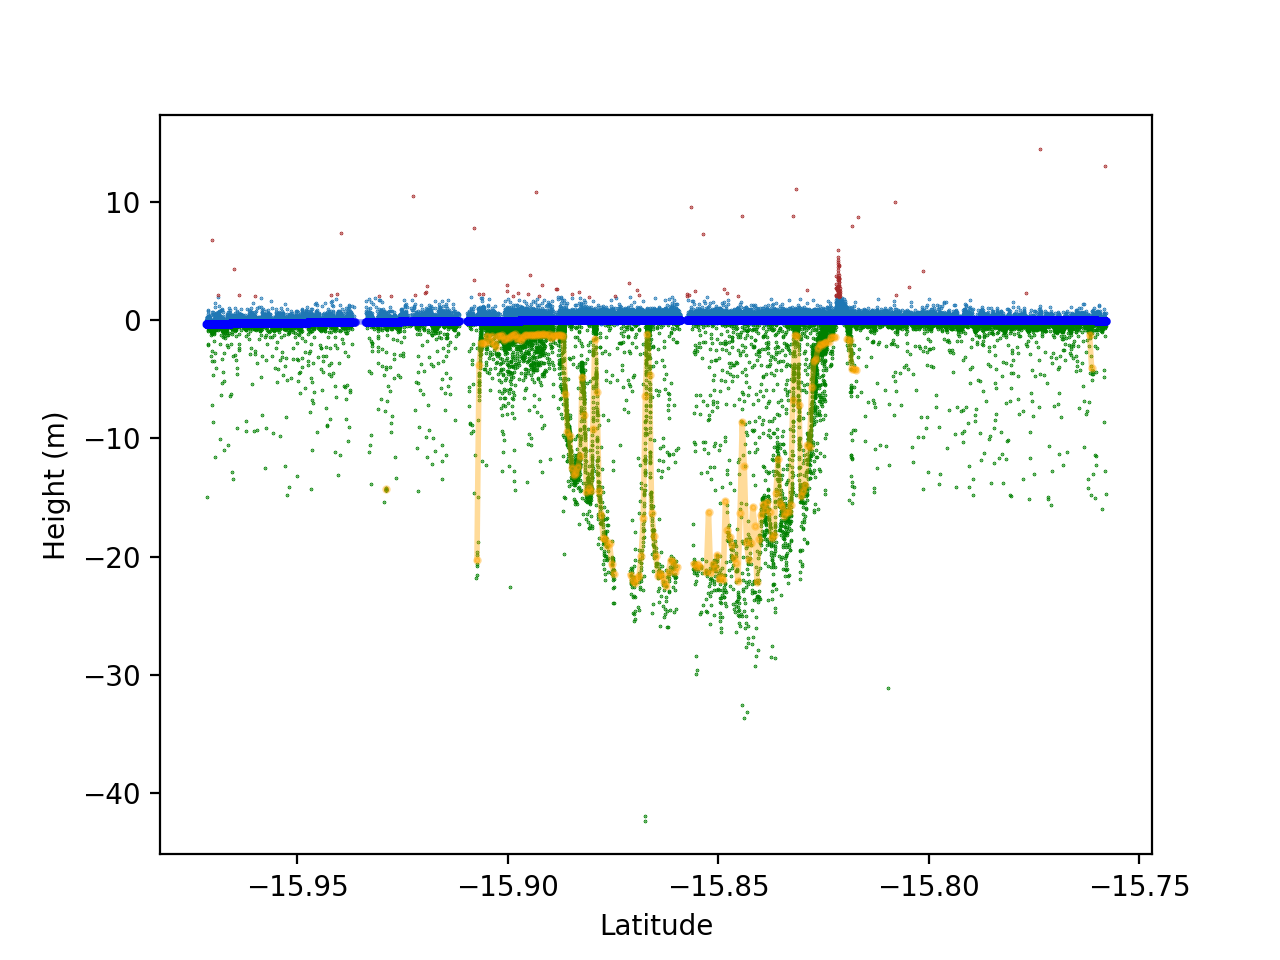

In [248]:
toau_coords = [-15.9736,-15.7580,-146.2402,-146.0953]
toau_depth, toau = get_depths('Toau', 'ATL03_20190126081429_04410208_001_01.h5', 'gt2l',toau_coords )

## Niau

[  1.0238858 -38.950947    0.7450709 ...   1.2911046   1.6058772
   1.6425532]
[-146.33165519 -146.33165799 -146.33165648 ... -146.34635386 -146.34635446
 -146.34635446]
[[ 4  4 -1 -1  4]
 [ 0  0 -1 -1  0]
 [ 4  4 -1 -1  4]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


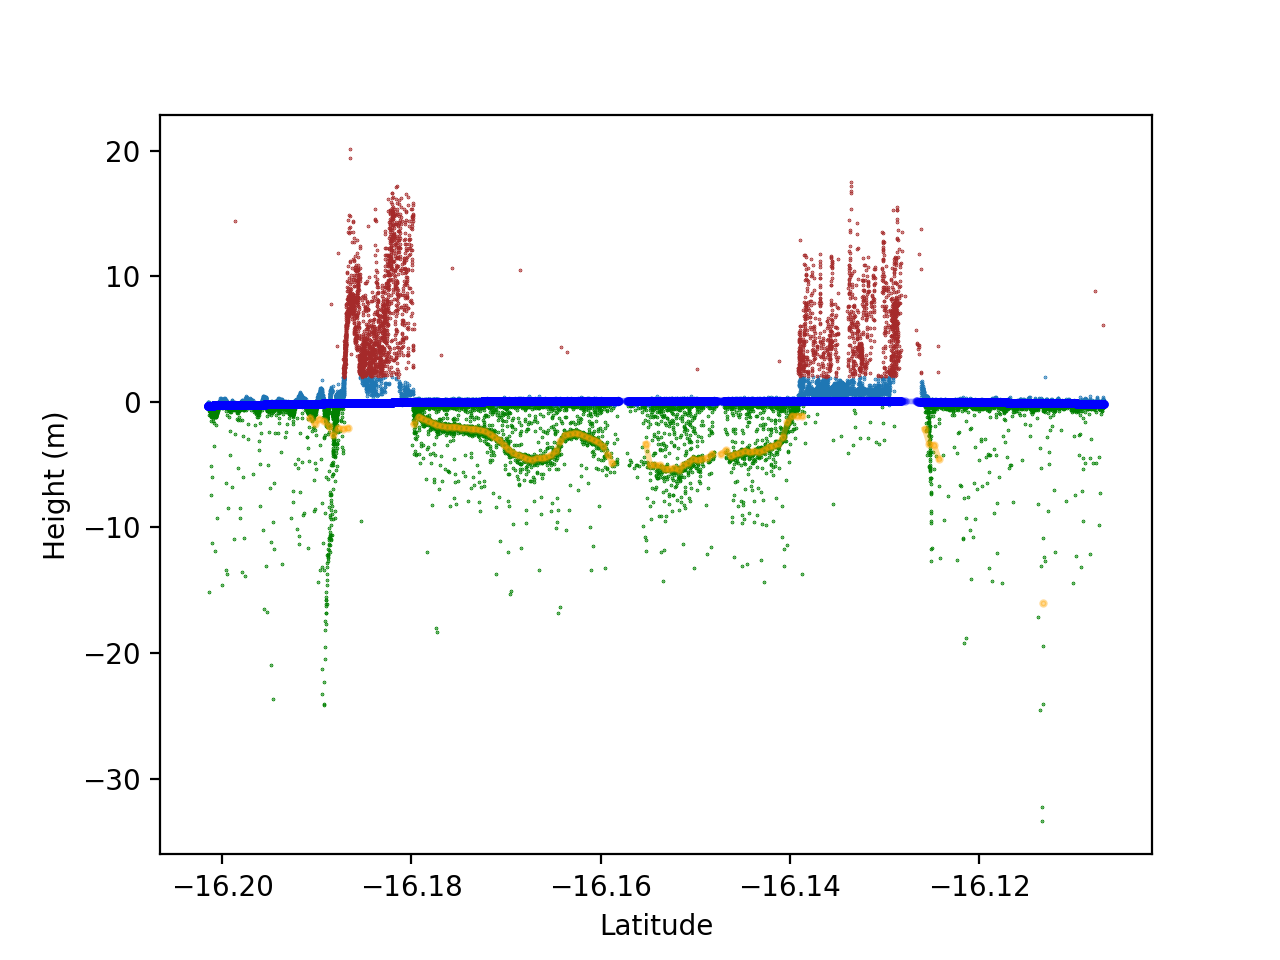

In [30]:
niau_coords = [-16.2015,-16.1068,-146.4057,-146.3020]
niau_depth, niau = get_depths('Niau', 'ATL03_20181228093820_13860108_001_01.h5', 'gt3r',niau_coords )

## Nasau (Fiji)

-0.219


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


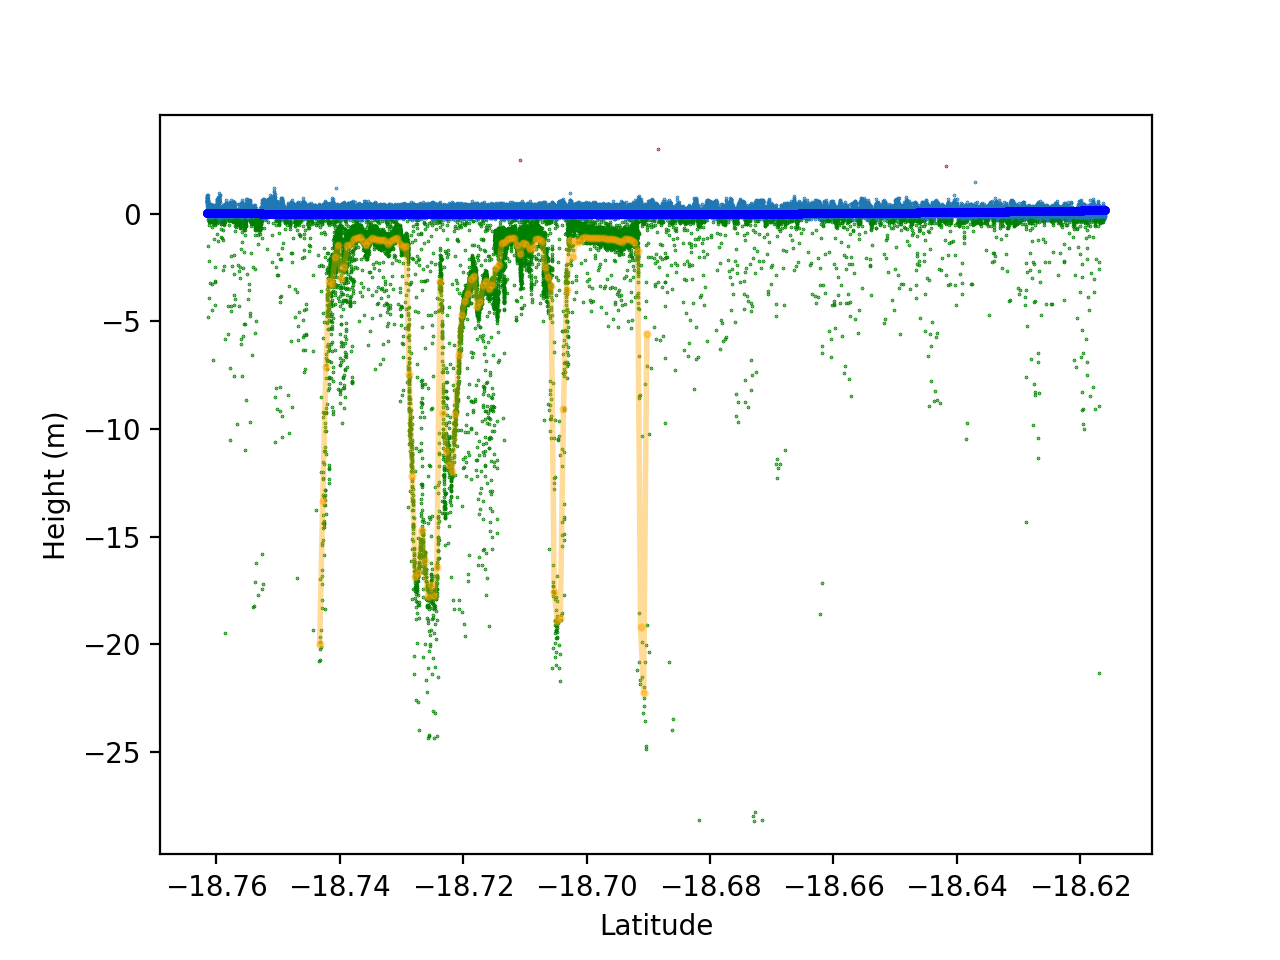

In [87]:
nasau_depth, nasau = get_depths('Nasau', 'gt1r')
plot(nasau, nasau_depth )

-0.219


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


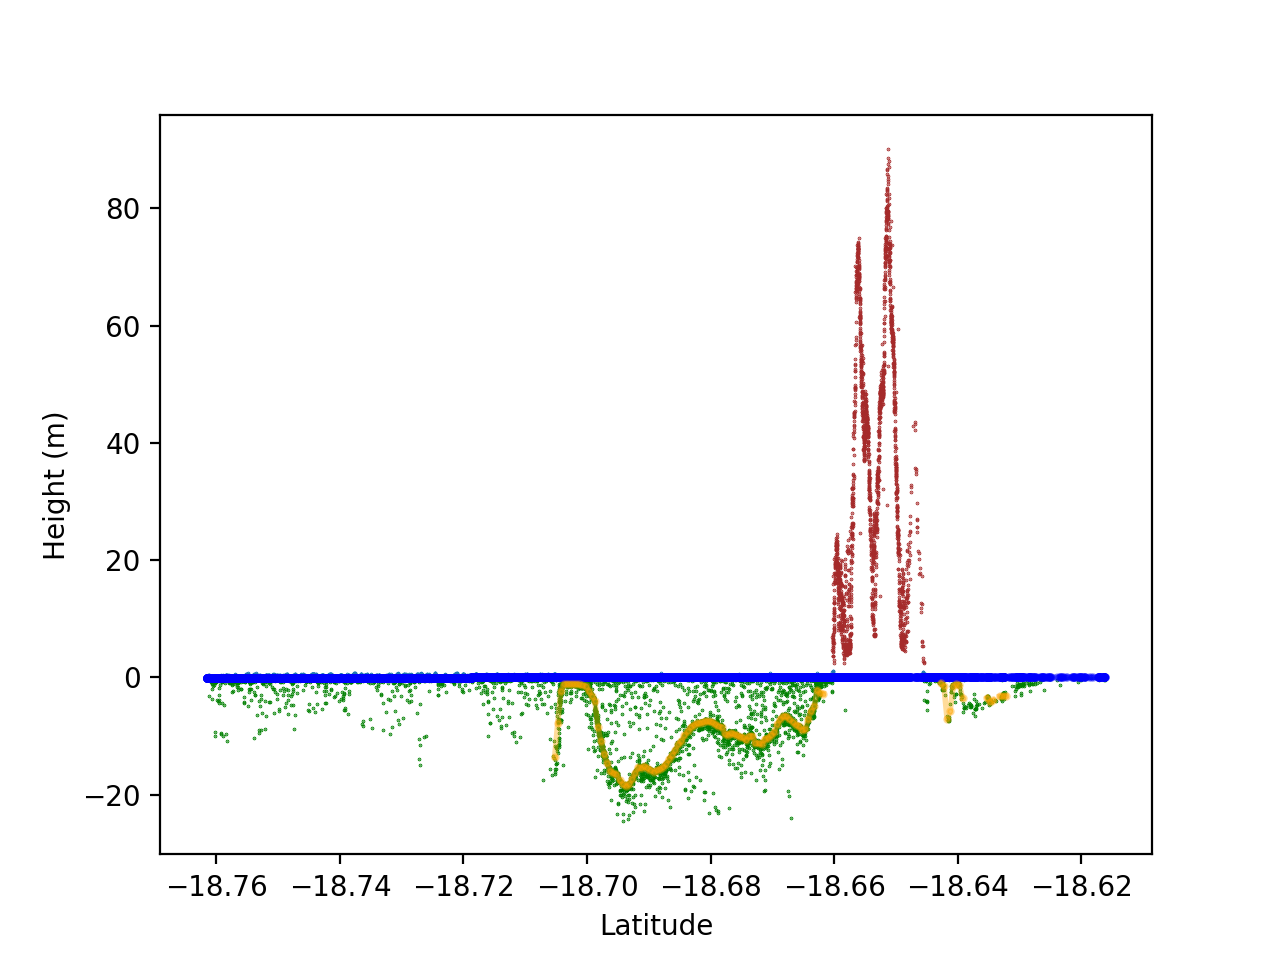

In [88]:
nasau_depth2, nasau2 = get_depths('Nasau', 'ATL03_20181210123712_11130108_001_01.h5', 'gt2r',nasau_coords )
plot(nasau2, nasau_depth2)

-0.219


/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<IPython.core.display.Javascript object>


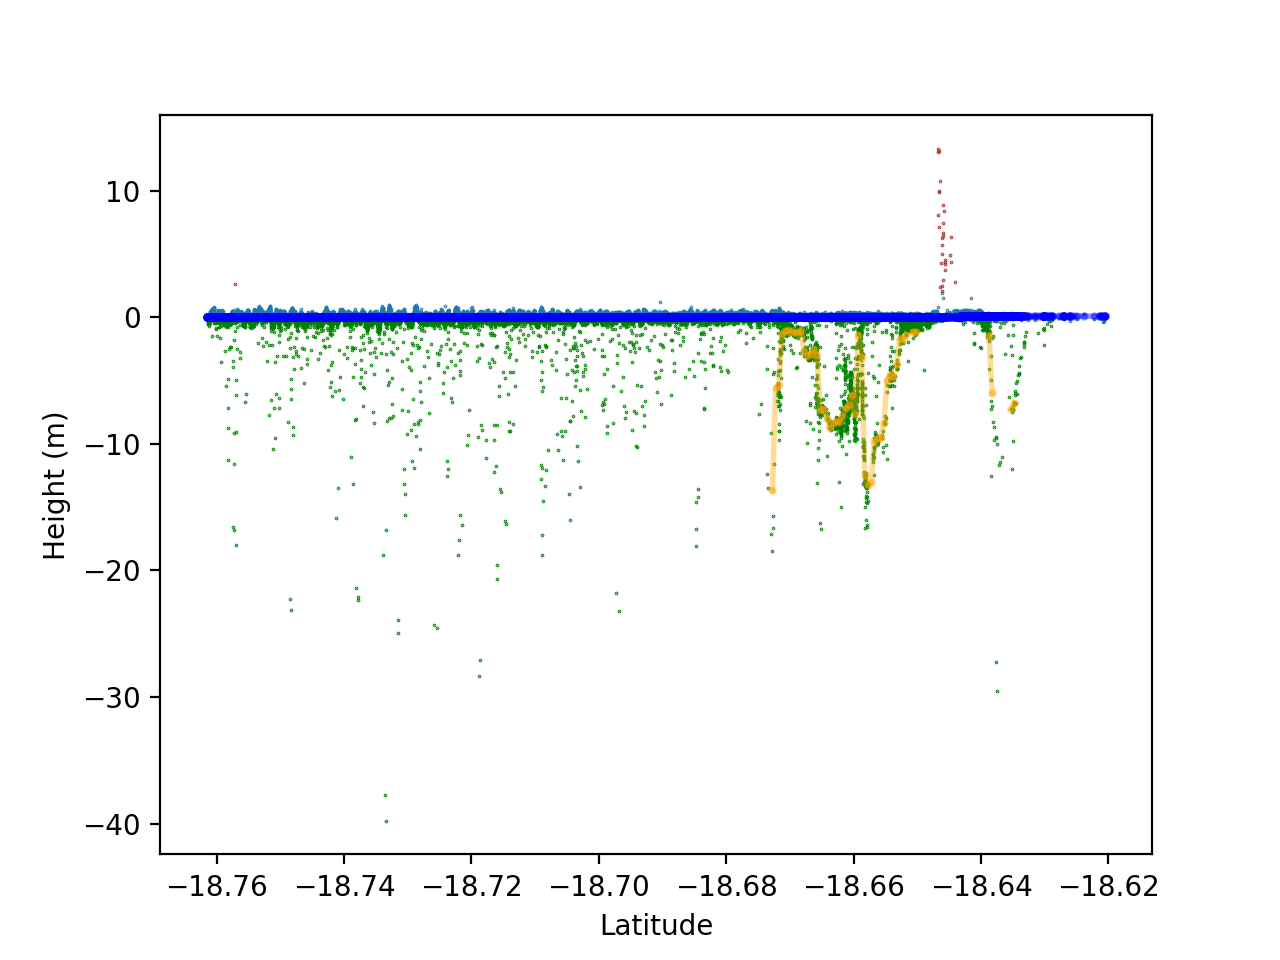

In [89]:
nasau_depth3, nasau3 = get_depths('Nasau', 'ATL03_20181210123712_11130108_001_01.h5', 'gt3r',nasau_coords )
plot(nasau3, nasau_depth3)

## Fulanga

<IPython.core.display.Javascript object>


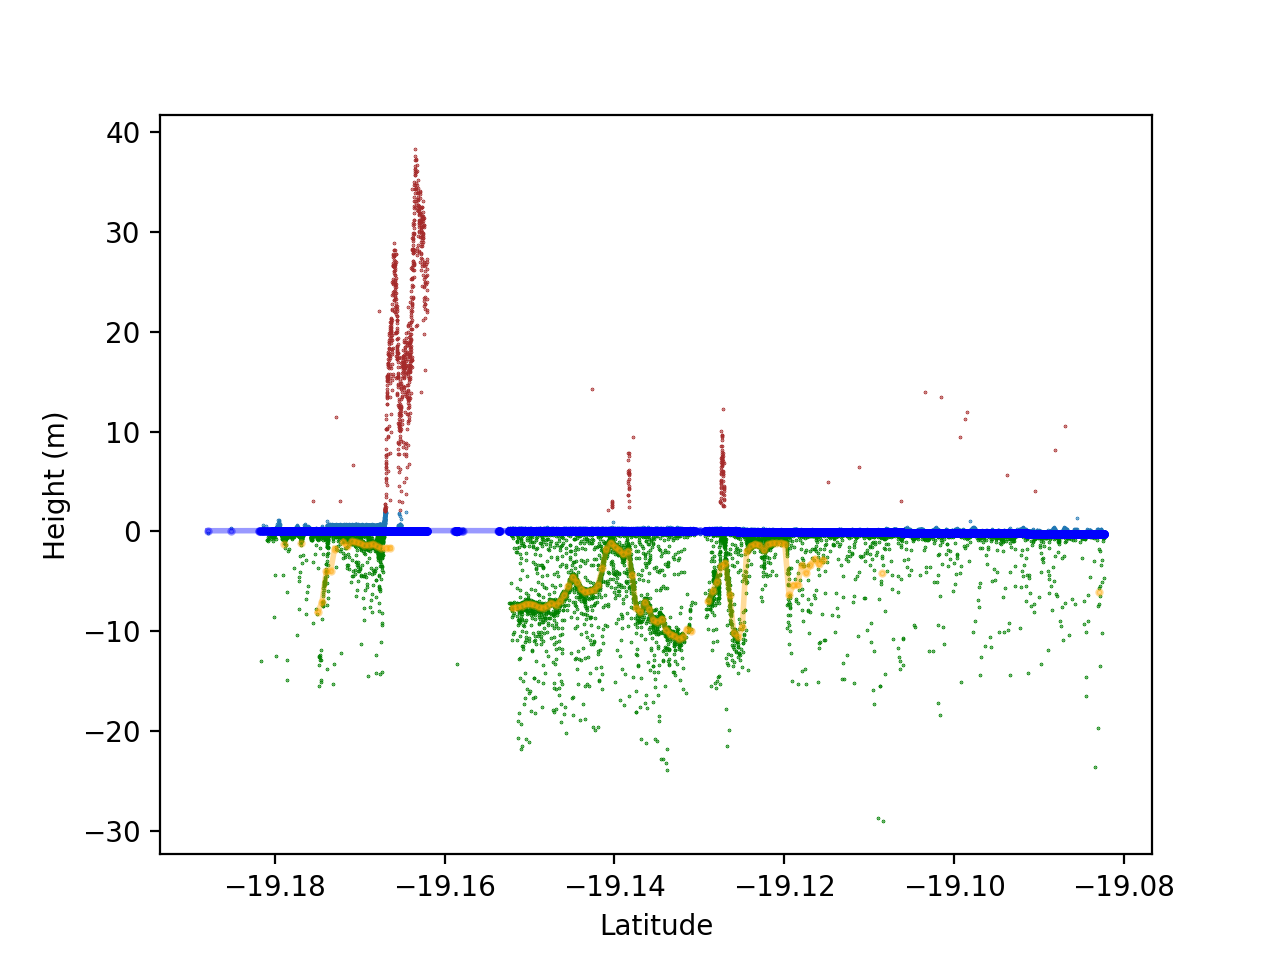

In [252]:
fulanga_coords = [-19.1882,-19.0823,-178.6238,-178.5150]
fulanga_depth, fulanga = get_depths('Fulanga', 'ATL03_20181210123712_11130108_001_01.h5', 'gt2r',fulanga_coords )

## Alice Town (Bahamas)

[-30.23401  -29.875664 -30.169155 ... -28.258102 -28.14664  -28.070318]
[-79.11929205 -79.1192921  -79.11929205 ... -79.20874115 -79.20874186
 -79.20874187]
[[ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]]


<IPython.core.display.Javascript object>


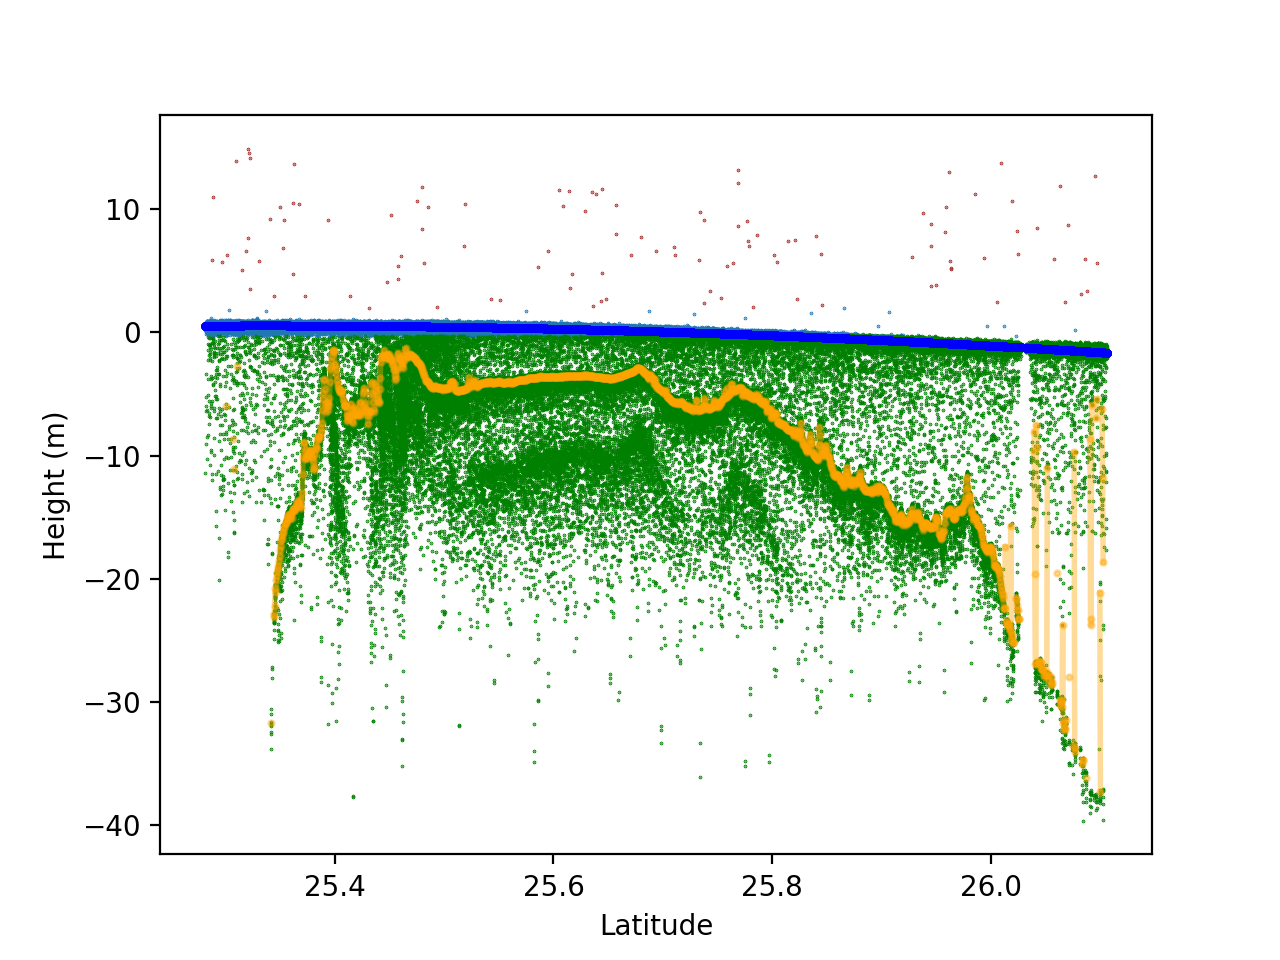

In [32]:
at_coords = [25.2571,26.1058,-79.3022,-79.0907]
at_depth, at = get_depths('Alice_Town', 'ATL03_20190108044907_01640207_001_01.h5', 'gt1l',at_coords )

[-29.985596 -29.798769 -29.772917 ... -28.253765 -28.05643  -28.170254]
[-79.15134071 -79.15134073 -79.15134073 ... -79.24055186 -79.24055258
 -79.24055257]
[[ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

<IPython.core.display.Javascript object>


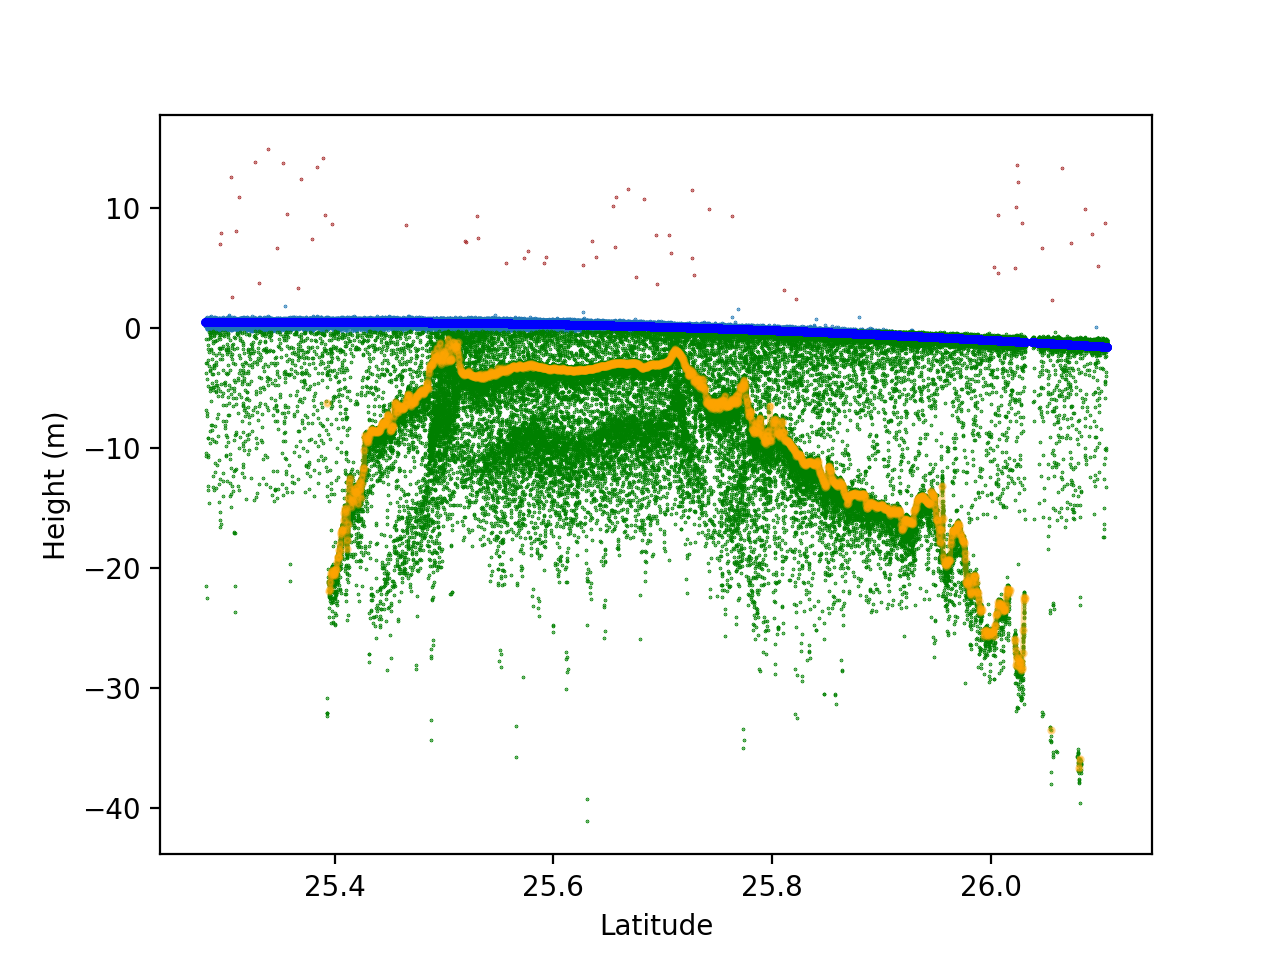

In [33]:
at_depth2, at2 = get_depths('Alice_Town', 'ATL03_20190108044907_01640207_001_01.h5', 'gt2l',at_coords )

[-29.855286 -30.37027  -29.814    ... -28.288076 -28.086779 -28.329435]
[-79.18344472 -79.18344539 -79.18344539 ... -79.27243662 -79.27243736
 -79.27243736]
[[ 4  4 -1 -1 -1]
 [ 4  4 -1 -1 -1]
 [ 4  4 -1 -1 -1]
 ...
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]
 [ 4  4 -1 -1  4]]


<IPython.core.display.Javascript object>


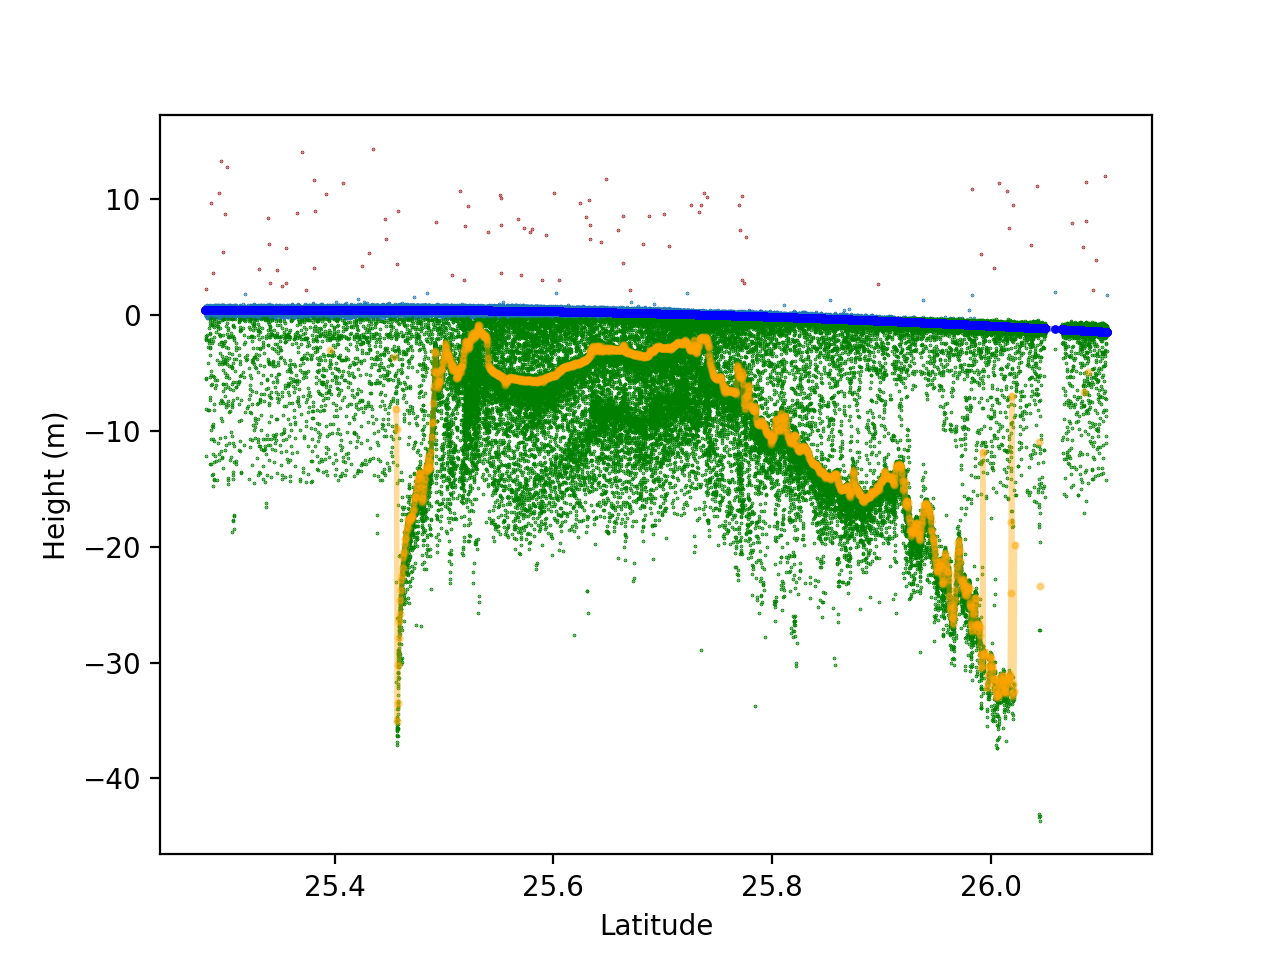

In [34]:
at_depth3, at3 = get_depths('Alice_Town', 'ATL03_20190108044907_01640207_001_01.h5', 'gt3l',at_coords )